# Calculating credit worthiness for rural India


### Context

In Banking industry, loan applications are generally approved after a thorough background check of the customer's repayment capabilities. Credit Score plays a significant role in identifying customer's financial behavior (specifically default). However, people belonging to rural India don't have credit score and it is difficult to do a direct assessment.

### Questions
1. __There is a new customer who needs a loan. Which models will be best suited to predict the loan_amount that can be granted to the customer?__

According to the anaysis in this notebook, a XGboost or a Random Forest regressor model would be best suited.

2. __Which all variables are good predictors?__

The following variables are good predictors (from Catboost model):
- Primary business
- Annual income to dependent ratio
- Loan instalments
- House area
- Annual savings
- Loan tenure
- Sanitary and water availability


3. __Build atleast one model from scratch that fits this data.__

I've built a linear regression model (with L2 regularisation) that can be found towards the end of this notebook.

4. __Is loan_purpose a significant predictor? The business has insisted on using loan_purpose as a predictor. If it is not already a significant contributor, can we still modify the model to include it?__

No, loan_purpose is not a significant predictor, although I used target encoding (also tried on-hot encoding). One might try combining the levels in an ad-hoc manner.


5. __How will you measure the fitness of the model? Which metrics (accuracy, recall, etc.) are most relevant?__

RMSE.




In [683]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,chi2,f_regression
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV ,RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.metrics import mean_squared_error as mse
import category_encoders as ce
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool
from xgboost.sklearn import XGBRegressor


In [527]:
data = pd.read_csv('trainingData.csv')

In [528]:
print(data.shape)
data.head()

(40000, 21)


,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,...,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [529]:
data.columns

Index(['Id', 'city', 'age', 'sex', 'social_class', 'primary_business',
       'secondary_business', 'annual_income', 'monthly_expenses',
       'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house',
       'occupants_count', 'house_area', 'sanitary_availability',
       'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments',
       'loan_amount'],
      dtype='object')

In [530]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
Id                       40000 non-null int64
city                     38136 non-null object
age                      40000 non-null int64
sex                      40000 non-null object
social_class             34745 non-null object
primary_business         39974 non-null object
secondary_business       34759 non-null object
annual_income            40000 non-null float64
monthly_expenses         39880 non-null float64
old_dependents           40000 non-null int64
young_dependents         40000 non-null int64
home_ownership           39621 non-null float64
type_of_house            39306 non-null object
occupants_count          40000 non-null int64
house_area               40000 non-null float64
sanitary_availability    39792 non-null float64
water_availabity         34747 non-null float64
loan_purpose             39974 non-null object
loan_tenure              40000 non-null int6

- There are 7 columns with 'object' datatype that are categorical variables with string values.

In [531]:
data.describe() # for numeric feature types

,Id,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availabity,loan_tenure,loan_installments,loan_amount
count,40000.00000,40000.00000,4.000000e+04,39880.000000,40000.000000,40000.00000,39621.000000,40000.000000,40000.000000,39792.000000,34747.000000,40000.000000,40000.000000,4.000000e+04
mean,20000.50000,55.15990,3.764021e+04,3810.875401,0.044900,1.13710,0.972489,26.641000,552.804750,0.686369,0.753216,12.032225,21.761175,8.412593e+03
std,11547.14972,3830.35566,2.873912e+04,4592.958009,0.222003,1.07384,0.163568,4749.995485,4596.921905,0.464028,0.255337,1.367473,16.682458,1.359694e+04
min,1.00000,2.00000,0.000000e+00,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3.000000,0.000000,1.000000e+02
25%,10000.75000,29.00000,1.440000e+04,2500.000000,0.000000,0.00000,1.000000,2.000000,200.000000,0.000000,0.500000,12.000000,12.000000,5.000000e+03
50%,20000.50000,35.00000,3.600000e+04,3500.000000,0.000000,1.00000,1.000000,3.000000,400.000000,1.000000,1.000000,12.000000,12.000000,8.000000e+03
75%,30000.25000,42.00000,5.600000e+04,4000.000000,0.000000,2.00000,1.000000,4.000000,600.000000,1.000000,1.000000,12.000000,50.000000,1.000000e+04
max,40000.00000,766105.00000,1.200000e+06,240000.000000,3.000000,7.00000,1.000000,950000.000000,700000.000000,1.000000,1.000000,84.000000,84.000000,1.343000e+06


__Few observations:__
- Max age is absurd.
- Max occupant count is absurd.
- Maximum house area seems to be an outlier.
- Minimum monthly expense is 2.
- Minimum loan instalment is 0.
- The loan amount varies over two orders of magnitude.
- There are a few features with missing values.
- The difference between loan instalments and loan tenure is not clear, although I verified that both are reported in units of months.
The dataset is not clean.

## Exploratory analysis

- First let's take a look at the pairwise correlations between the numeric data types in the dataframe. A heatmap illustrates this well.

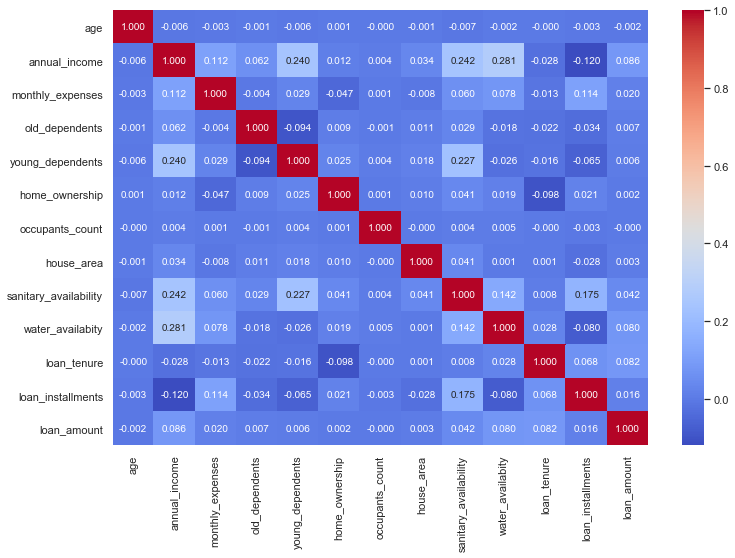

In [532]:
plt.figure(figsize = (12,8))
sns.heatmap(data.drop('Id',axis=1).corr(), cmap = 'coolwarm', annot=True, fmt='.3f');

- The problem of multicollinearity seems to be absent in the dataset, which is a good sign. But there are quite a few nominal categorical variables which are already encoded for us.
- Sanitary and water availability seems to be relatively more correlated with annual income, which also makes sense.
- None of the features seem to be highly correlated with the response variable *loan_amount*, which hints at the fact that linear models might not perform well in this regression task, since the Pearson correlation essentially measures the strength of the linear relationship.

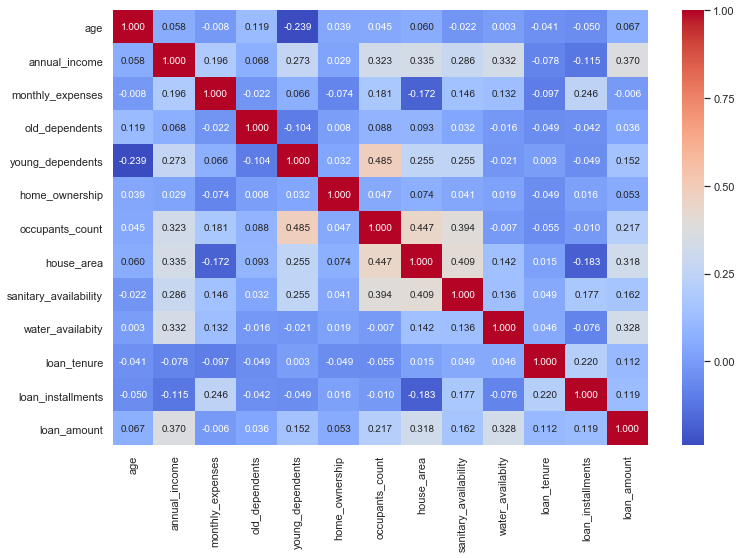

In [533]:
# Spearman correlation matrix

plt.figure(figsize = (12,8))

sns.heatmap(data.drop('Id',axis=1).corr(method='spearman'), cmap = 'coolwarm', annot=True, fmt='.3f');

#### Monthly expenses

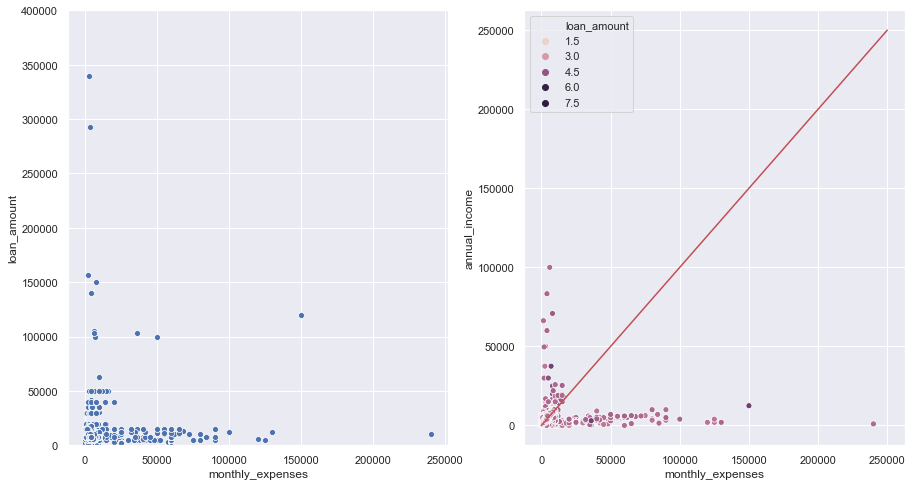

In [534]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
sns.scatterplot(data.monthly_expenses, data.loan_amount, ax=ax[0]);
sns.scatterplot(data.monthly_expenses, data.annual_income/12, hue=np.log10(data.loan_amount),ax=ax[1]);
X_plot = np.linspace(0, 250000, 2)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='r');
ax[0].set_ylim(0,400000);

In [536]:
df_exp = data.dropna(subset = ['monthly_expenses'])[['monthly_expenses', 'annual_income', 'loan_amount']]
annual_savings = df_exp.annual_income - (df_exp.monthly_expenses*12)
df_exp['annual_savings'] = annual_savings
df_exp.corr(method='spearman')

,monthly_expenses,annual_income,loan_amount,annual_savings
monthly_expenses,1.000000,0.196250,-0.005996,-0.360245
annual_income,0.196250,1.000000,0.370394,0.801337
loan_amount,-0.005996,0.370394,1.000000,0.382066
annual_savings,-0.360245,0.801337,0.382066,1.000000


In [537]:
data['annual_savings'] = df_exp['annual_savings']

#### Age

In [538]:
data.age.describe()

count     40000.00000
mean         55.15990
std        3830.35566
min           2.00000
25%          29.00000
50%          35.00000
75%          42.00000
max      766105.00000
Name: age, dtype: float64

In [539]:
data.age.sort_values(ascending=False)

10236    766105
11993       288
9337        205
38189        88
35555        82
          ...  
21687        18
29295        18
8620         18
11732         2
11837         2
Name: age, Length: 40000, dtype: int64

In [540]:
data[data.age == 766105]

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount,annual_savings
10236,10237,Kendubahara,766105,F,NaN,Dry fish selling,NaN,0.0,1000.0,0,...,T1,0,0.0,0.0,NaN,Meat Businesses,12,12,3000.0,-12000.0


- There are certain bogus values in the age feature which are impossible.
- Drop the rows with anomalous age values.

In [541]:
data = data.drop([10236, 11993,9337, 11732, 11837], axis = 0)

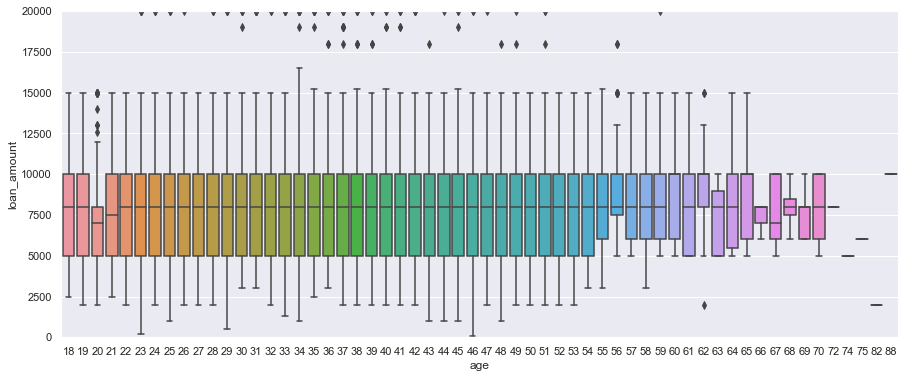

In [542]:
plt.figure(figsize=(15,6))
#sns.scatterplot(data.age, data.loan_amount);
#plt.yscale('log')
plt.ylim(0,20000)
sns.boxplot(data.age, data.loan_amount);

- The box plot above is not much informative. It is probably better to group the customers acording to their age groups.
- I'll use the Pandas cut method to bin the ages into four groups.

In [543]:
data.age.describe()

count    39995.000000
mean        35.999350
std          8.923522
min         18.000000
25%         29.000000
50%         35.000000
75%         42.000000
max         88.000000
Name: age, dtype: float64

In [544]:
pd.cut(data['age'], bins=[data.age.min(),30,45,60,data.age.max()], labels=["young", "mid-age", "senior", "old"]).value_counts()

mid-age    21140
young      12705
senior      5946
old          111
Name: age, dtype: int64

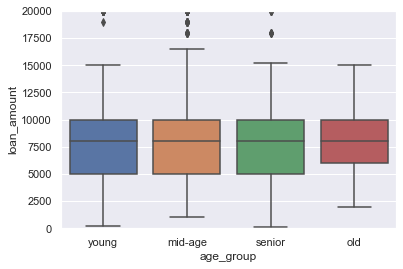

In [545]:
data.loc[:, 'age_group'] =pd.cut(data['age'], bins=[data.age.min(),30,45,60,data.age.max()], labels=["young", "mid-age", "senior", "old"])
sns.boxplot(data.age_group, data.loan_amount)
plt.ylim(0,20000);

- I'll now drop the *Age* feature and label-encode the *age_group* feature.

In [546]:
data.drop('age',axis=1,inplace =  True)
data.loc[:, 'age_group'] = data.age_group.map({'young':1, "mid-age":2, "senior":3, "old":4})
data.loc[:, 'age_group'] = data.loc[:,'age_group'].astype('int')

#### house area

In [547]:
data.house_area.describe()

count     39995.000000
mean        552.873859
std        4597.205091
min           0.000000
25%         200.000000
50%         400.000000
75%         600.000000
max      700000.000000
Name: house_area, dtype: float64

(1, 100000)

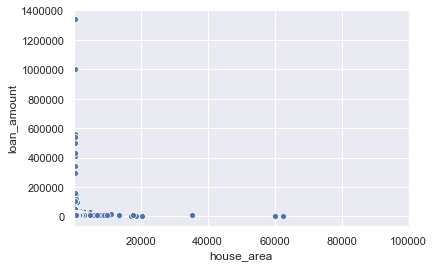

In [548]:
sns.scatterplot(data[data.house_area>0].house_area, data[data.loan_amount>0].loan_amount);
plt.xlim(1,100000)

In [549]:
df_ha_0_ho_1 = data.loc[data.house_area==0,[ 'home_ownership']]
display(df_ha_0_ho_1)
print("No. of cases where house area is 0 bt the person owns a home: {}".format(df_ha_0_ho_1.sum().values[0]))

,home_ownership
7585,NaN
7586,NaN
7587,NaN
7588,NaN
7589,NaN
...,...
12844,1.0
18961,0.0
18962,0.0
19004,0.0


No. of cases where house area is 0 bt the person owns a home: 4506.0


- There are a certain number of cases where house area = 0, but home_ownership = 1. This is odd.

#### Occupant count

In [550]:
data.occupants_count.value_counts()

4         10331
2          9461
3          8611
0          5263
5          2914
1          2454
6           689
7           154
8            57
10           26
9            16
600           5
12            2
300           2
15            2
700           1
11            1
900           1
100           1
400           1
450           1
250           1
950000        1
Name: occupants_count, dtype: int64

- Clearly it is impossible to have  950000 occupants in a house, it's probably a typo.
- I would also not trust occupant counts > 100. Therefore I'll replace all such occurences with the modal value, i.e. 4.

In [551]:
num_occ_mode = int(data.occupants_count.mode())
data.loc[:, 'occupants_count'] = data.loc[:, 'occupants_count'].apply(lambda num_occ: num_occ_mode if num_occ >=15 else num_occ)

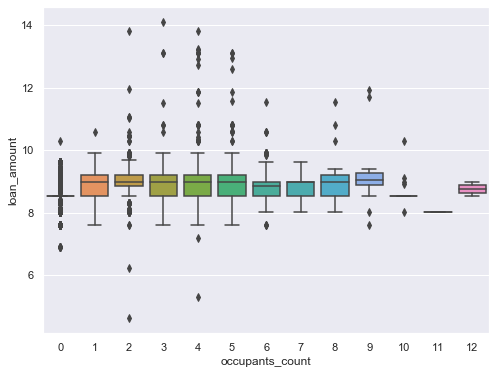

In [552]:
plt.figure(figsize=(8,6))
sns.boxplot(data.occupants_count, np.log(data.loan_amount));

- Based on the box plot above, *occupants_count* is not expected to be a strong predictor of the loan amount. This should reflect in the feature importances later while building the predictor model.

#### Old and young dependents

In [553]:
display(pd.DataFrame(data['old_dependents'].value_counts()))
display(pd.DataFrame(data['young_dependents'].value_counts()))

,old_dependents
0,38326
1,1543
2,125
3,1


,young_dependents
0,14772
2,11384
1,9837
3,3269
4,620
5,90
6,19
7,4


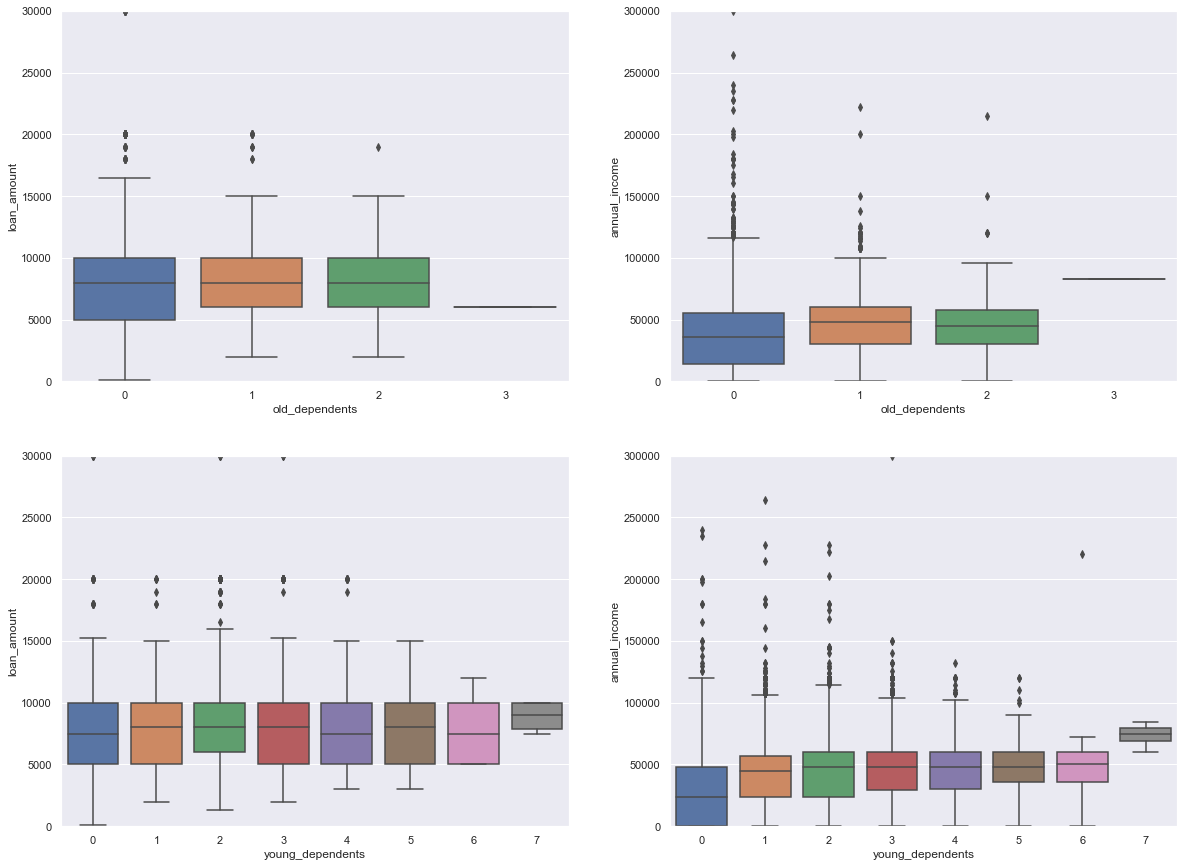

In [554]:
fig,ax = plt.subplots(2,2, figsize=(20,15))
sns.boxplot(data.old_dependents, data.loan_amount, ax=ax[0][0]);
sns.boxplot(data.old_dependents, data.annual_income, ax=ax[0][1]);
sns.boxplot(data.young_dependents, data.loan_amount, ax=ax[1][0]);
sns.boxplot(data.young_dependents, data.annual_income, ax=ax[1][1]);
ax[0][0].set_ylim(0,30000);
ax[1][0].set_ylim(0,30000);
ax[0][1].set_ylim(0,300000);
ax[1][1].set_ylim(0,300000);

In [555]:
data[['old_dependents', 'young_dependents', 'loan_amount', 'annual_income']].corr(method='spearman')

,old_dependents,young_dependents,loan_amount,annual_income
old_dependents,1.000000,-0.103575,0.036063,0.067686
young_dependents,-0.103575,1.000000,0.152315,0.273138
loan_amount,0.036063,0.152315,1.000000,0.369809
annual_income,0.067686,0.273138,0.369809,1.000000


In [556]:
# Try out a  new feature, income to total dependents ratio

inc_by_dep = data.annual_income/(1+data.old_dependents + data.young_dependents)
print(inc_by_dep.corr(data.loan_amount, method='spearman'))
data['inc_by_dep'] = inc_by_dep

0.3609299184737666


#### Home ownership

1.0    0.963295
0.0    0.027228
Name: home_ownership, dtype: float64

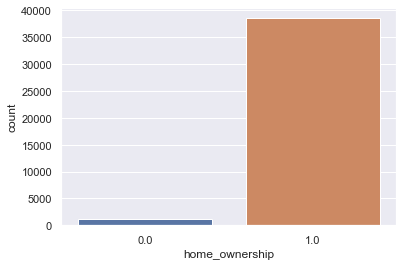

In [557]:
sns.countplot(data.home_ownership);
data.home_ownership.value_counts()/data.shape[0]

- Most people (96%) in the dataset own a house. This might be due to two reasons:
    - It's relatively easier and cheaper to own a house in the rural areas.
    - The dataset contains data of those who have been granted a loan and repaid in full. Owning a house might be an important criterion for lenders to given a loan in the first place.

In [558]:
data.groupby('home_ownership')['annual_income','loan_installments', 'loan_amount'].agg(['mean', 'median'])

annual_income          loan_installments         loan_amount  \
                        mean   median              mean median         mean   
home_ownership                                                                
0.0             36009.641873  36000.0         19.670340     12  8281.634527   
1.0             38061.465388  39600.0         21.864277     12  8440.846679   

                        
                median  
home_ownership          
0.0             5000.0  
1.0             8000.0

In [559]:
# Sanitary and water availability

display(pd.DataFrame(data.sanitary_availability.value_counts()))
display(pd.DataFrame(data.water_availabity.value_counts()))

,sanitary_availability
1.0,27313
0.0,12473
-1.0,1


,water_availabity
1.0,17782
0.5,16782
0.0,182
-1.0,1


- The sanitary and water availability seem to be ordinal categorical variables which has already been encoded.

In [560]:
data.loc[:, 'san_water_availability'] = data.sanitary_availability+data.water_availabity
data.san_water_availability.value_counts()

 2.0    14898
 1.5    12379
 0.5     4403
 1.0     2920
 0.0      146
-2.0        1
Name: san_water_availability, dtype: int64

## Categorical variables: nominal

In [561]:
# Categorical variables with dtype = object
data.select_dtypes(exclude=np.number).head()

,city,sex,social_class,primary_business,secondary_business,type_of_house,loan_purpose
0,Dhanbad,F,Mochi,Tailoring,Others,R,Apparels
1,Manjapra,F,OBC,Tailoring,none,T1,Apparels
2,Dhanbad,M,Nai,Beauty salon,Others,T1,Beauty Salon
3,NaN,F,OBC,Tailoring,none,T1,Apparels
4,Nuapada,F,OBC,General store,Agriculture,T1,Retail Store


#### Sex

F     37617
M      2371
TG        7
Name: sex, dtype: int64

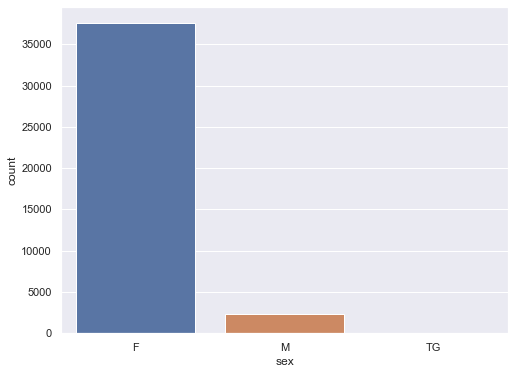

In [562]:
plt.figure(figsize=(8,6))
sns.countplot(data.sex);
data.sex.value_counts()

In [563]:
data.groupby('sex')['loan_amount'].agg(['mean', 'median'])

,mean,median
sex,,
F,8375.832735,8000.0
M,9001.054407,10000.0
TG,9000.000000,8000.0


(0, 20000)

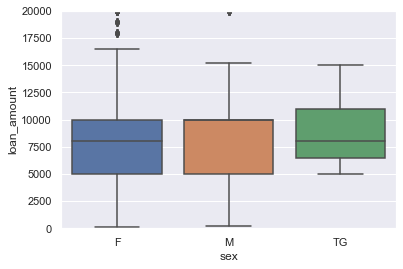

In [564]:
sns.boxplot(data.sex, data.loan_amount);
plt.ylim(0,20000)

- The dataset is heavily skewed in favour of female applicants.
- The mean loan amount given to female applicants is slightly lower than those given to men.
- I don't expect sex to be a good predictor for loan amount.

#### City

In [565]:
data.city.value_counts()

Pusad              3153
Bahoriband         1979
PUSAD              1776
Shantipur          1727
Imphal             1699
                   ... 
Surendhra nagar       1
Chadheigaon           1
Surendra nagar        1
Bhutupara             1
HD Koe                1
Name: city, Length: 856, dtype: int64

- Convert all strings to lowercase. This will automatically introduce some grouping of levels.

In [566]:
data.loc[:,'city'] = data.loc[:,'city'].apply(lambda city_name: np.nan if str(city_name) == 'nan' else str(city_name).lower())

In [567]:
data.city.value_counts()

pusad          4943
bahoriband     1979
shantipur      1727
imphal         1702
gwalior        1587
               ... 
banamalipur       1
bidar             1
paddadih          1
chadheigaon       1
latur             1
Name: city, Length: 767, dtype: int64

- Redundant levels: There are 767 different categories (city names), many of which have just a single entry. Since it is a nominal variable, one has to one-hot encode it which will create 767 new columns. To reduce the dimensionality, I'll combine or bunch the rare levels in to a single category which will represent 'other cities'.
- The threshold I have selected for this grouping is the 90th percentile of the frequency distribution of city names.

In [568]:
city_percentile_90 = np.percentile(data.city.value_counts(), 90)
print('The 90th percentile is at a value of {}'.format(int(city_percentile_90)))
print('No. of cities above 90th percentile = {}'.format(np.sum(data.city.value_counts() > city_percentile_90)))

The 90th percentile is at a value of 67
No. of cities above 90th percentile = 76


In [569]:
cities_le_90p =  (data.city.value_counts() < city_percentile_90)*1

other_cities = list(cities_le_90p[cities_le_90p == 1].index)
print('{} cities will be grouped together.'.format(len(other_cities)))

688 cities will be grouped together.


In [570]:
data.loc[:, 'city'] = data.loc[:,'city'].apply(lambda city_name: 'other' if (str(city_name) == 'nan' or cities_le_90p[city_name] == 1) else city_name)

In [571]:
def group_levels(column_name, percentile, new_cname = 'Others'):
    '''
    Group levels in a categorical column depending on percentile counts.
    '''
    perc_val = np.percentile(data[column_name].value_counts(), percentile)
    print('The {} percentile is at a value of {}.'.format(percentile, perc_val))
    print('{} levels are above the {} percentile'.format(np.sum(data[column_name].value_counts() > perc_val), percentile))
    levels_le_perc = (data[column_name].value_counts() < perc_val)*1
    other_levels = list(levels_le_perc[levels_le_perc == 1].index)
    print('{} levels will be grouped together.'.format(len(other_levels)))
    df = data.loc[:, column_name].apply(lambda x: 'Others' if levels_le_perc[x] == 1 else x)
    return df

#### Social class

In [572]:
print('There are {} unique categories in social class'.format(data.social_class.nunique()))
data['social_class'].value_counts()[:50]

There are 519 unique categories in social class


OBC               10683
SC                 3136
ST                 2616
General            2299
Muslim             1743
S.C                 950
Minority            892
Hindu               869
GC                  807
Sechudle Caste      769
G.C                 735
S.C.                529
Sc                  432
GEN                 413
Obc                 399
MUSLIM              375
NT                  373
BC                  337
General Caste       290
Gen                 288
S.c                 244
VJNT                229
GENERAL             215
Mahar               194
Open                190
Lingahitha          180
Christian           174
Ezhava              170
S.T.                166
Schudle Cast        160
sc                  154
Maratha             153
S.T                 153
O.B.C               107
GENL                106
Kuruba               96
O.B.C.               90
obc                  87
Musilim              86
Bauddha              84
Nayaka               84
MBC             

- What one can notice from above is that there is no consistency while entering the caste/social class of a customer. There are many spelling mistakes which results in different variants of the same word, mix of uppercase and lowercase characters, and a single category expressed in both abbreviated and expanded from (e.g. SC and Scheduled Caste). 
- I have just converted all words to lowercase and removed full stops in individual strings. This alleviates the problem to some extent, but one has to do a lot of preprocessing to take all the inconsistencies in to account.
- One can use a suitable metric like the Jaccard distance to compute the similarity between two strings and combine strings which have a similarity score above a certain threshold. This will alleviate the problem of minor spelling mistakes.

In [573]:
def conv_lcase(s):
    if str(s) == 'nan':
        return np.nan 
    else:
        return str(s).lower()

def prep_str(s):
    '''Convert a string to lowercase and remove dots (if any)'''
    clean_s = conv_lcase(s)
    if type(clean_s) == str:
        return clean_s.replace('.', '')
    else:
        return clean_s

data.loc[:, 'social_class'] = data.loc[:,'social_class'].apply(lambda social_class: prep_str(str(social_class)))

In [574]:
data['social_class'].nunique()

443

In [575]:
data.social_class.fillna('obc', inplace = True)

In [576]:
group_levels('social_class',95).value_counts()

The 95 percentile is at a value of 107.6999999999997.
23 levels are above the 95 percentile
420 levels will be grouped together.


obc               16616
sc                 5520
st                 3015
general            2526
Others             2430
muslim             2131
gc                 1542
minority            965
hindu               902
sechudle caste      780
gen                 730
nt                  410
bc                  339
general caste       300
open                268
vjnt                238
mahar               199
christian           180
lingahitha          180
ezhava              173
maratha             161
schudle cast        160
genl                121
okkaliga            109
Name: social_class, dtype: int64

- I decide to exclude social_class from the training set because of numerous inconsistencies in the entries, as well as the fact that it is not supposed to be a strong predictor of loan approval/amount.

#### Primary business

In [577]:
data.primary_business.value_counts()

Tailoring                      3971
Goat rearing                   2267
Cow Rearing                    2077
Handloom Work                  2068
Vegetable cultivation          1704
                               ... 
Red sugar processing              1
loading Rickshaw                  1
Owner of small grocery shop       1
Mandapa/ Pendal Decoration        1
Mandap Decoratinon                1
Name: primary_business, Length: 441, dtype: int64

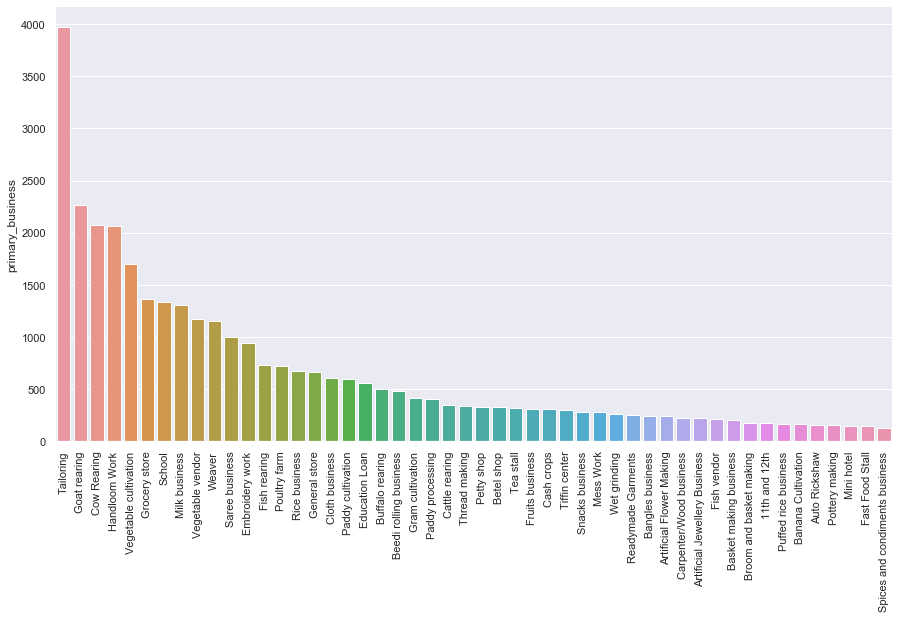

In [578]:
plt.figure(figsize = (15,8))
sns.barplot(x = data.primary_business.value_counts().index[:50], y = data.primary_business.value_counts()[:50]);
plt.xticks(rotation = 90);

In [579]:
data.loc[:, 'primary_business'].fillna('Tailoring', inplace = True)

In [580]:
data.primary_business.nunique()

441

In [581]:
group_levels('primary_business', 75).value_counts()

The 75 percentile is at a value of 38.0.
110 levels are above the 75 percentile
330 levels will be grouped together.


Tailoring                  3997
Goat rearing               2267
Others                     2112
Cow Rearing                2077
Handloom Work              2068
                           ... 
Mechanic                     39
Duck rearing                 39
Wooden toys business         39
Electronic items repair      39
Tobacco business             38
Name: primary_business, Length: 112, dtype: int64

In [582]:
data.loc[:,'primary_business'] = group_levels('primary_business', 75)

The 75 percentile is at a value of 38.0.
110 levels are above the 75 percentile
330 levels will be grouped together.


#### secondary business

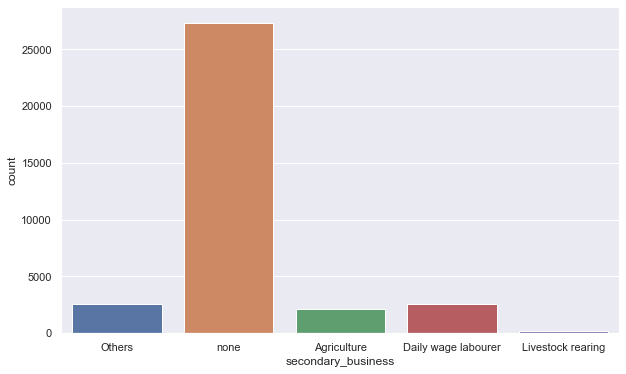

In [583]:
plt.figure(figsize = (10,6));
sns.countplot(data.secondary_business);

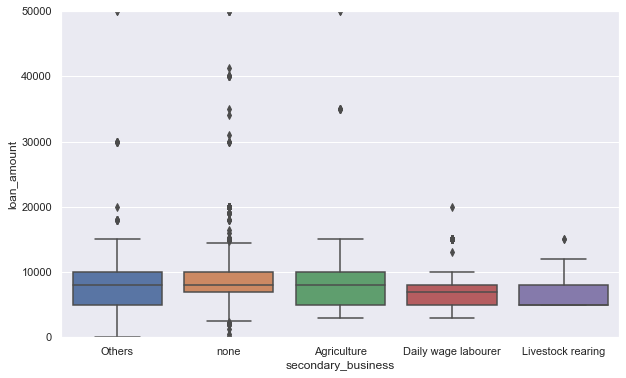

In [584]:
plt.figure(figsize = (10,6));
sns.boxplot(data.secondary_business, data.loan_amount);
plt.ylim(0,50000);

- There's no clear trend in the loan amount granted with respect to the secondary business. The median values of the different categories are comparable. The *none* category, which is the most abundant, has the lowest value of the interquartile range and the highest number of outliers.

#### Type of house

In [585]:
data.type_of_house.value_counts()

T2    17714
T1    15089
R      6498
Name: type_of_house, dtype: int64

- It is not specified on the problem statement what do these codes like T1 and T2 mean, so I'm going to treat the type of house as a nominal categorical variable and one-hot encode it.

(0, 20000)

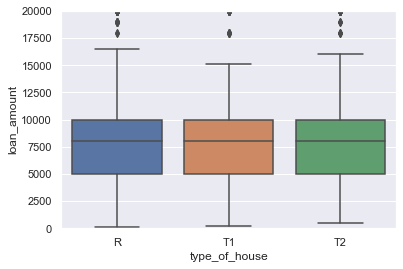

In [586]:
sns.boxplot(data.type_of_house,data.loan_amount);
plt.ylim(0,20000)

#### Loan purpose

In [587]:
data.loan_purpose.value_counts()

Apparels                           7064
Agro Based Businesses              4728
Animal husbandry                   4421
Meat Businesses                    4300
Handicrafts                        4230
Farming/ Agriculture               3284
Education Loan                     2100
Retail Store                       1962
Eateries                           1831
Business Services - II              854
Tobacco Related Activities          852
Construction Related Activities     661
Retail Sale                         614
Artifical Jewellry Selling          556
Carpentery work                     299
Food Items                          285
Business Services - I               276
Transportation Services             245
Flower Business                     238
Beauty Salon                        204
Repair Services                     192
Laundry Services                    162
Agarbatti Business                  107
Utensil Selling                     104
Sanitation                          101


In [588]:
data.groupby('loan_purpose')['loan_amount'].agg(['size', 'mean', 'median']).sort_values('mean', ascending = False)

,size,mean,median
loan_purpose,,,
Manufacturing,1,292400.000000,292400.0
Training,23,53826.086957,31000.0
Others,62,17693.548387,8000.0
Sanitation,101,12600.000000,12600.0
Tent Services,6,12500.000000,13500.0
Recycling/ Waste Management,100,12100.000000,8000.0
Professional,3,10000.000000,9000.0
Handicrafts,4230,9986.666667,9000.0
Education Loan,2100,9570.761905,8000.0


- The mean loan amount varies from 2500 to > 50,000 (for minimum count of 20).
- The median loan, on the other hand, is quite robust to the loan purpose. This signifies that although the median is roughly constant across loan purposes, there is considerable variance or spread in the amounts, as we'll see in the boxplot below.

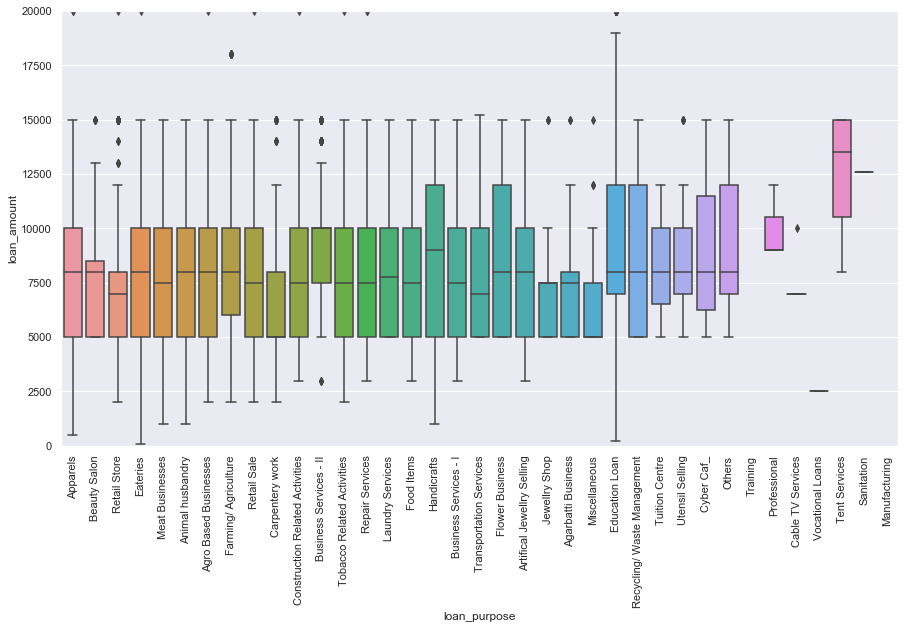

In [589]:
plt.figure(figsize=(15,8))
sns.boxplot(data.loan_purpose,data.loan_amount)
plt.xticks(rotation=90)
plt.ylim(0,20000);

In [590]:
data.loan_purpose.fillna('Apparels', inplace = True) # mode, simplest choice

In [591]:
data.loc[:, 'loan_purpose'] = group_levels('loan_purpose', 25)

The 25 percentile is at a value of 40.0.
27 levels are above the 25 percentile
9 levels will be grouped together.


### Drop highly correlated features

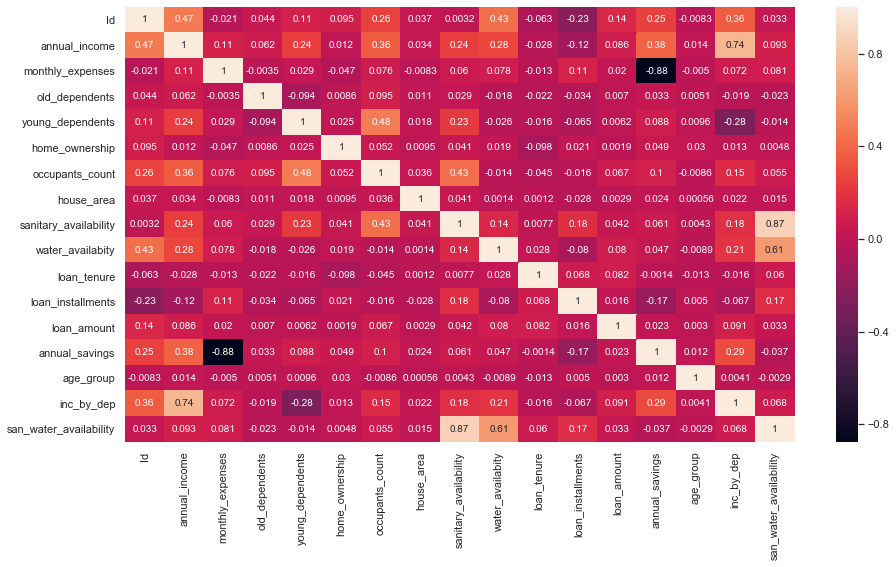

In [592]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True);

In [593]:
data.drop(['monthly_expenses', 'annual_income', 'water_availabity', 'sanitary_availability'], axis=1, inplace = True)

### Target variable: Loan amount

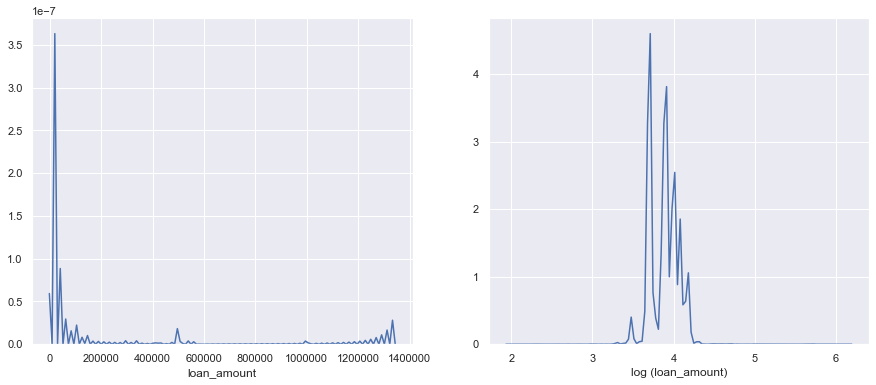

In [594]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.distplot(data.loan_amount, hist=False, ax = ax[0]);
sns.distplot(np.log10(data.loan_amount), hist=False, ax = ax[1]);
ax[1].set_xlabel('log (loan_amount)');

- The target variable is *not* normally distributed.

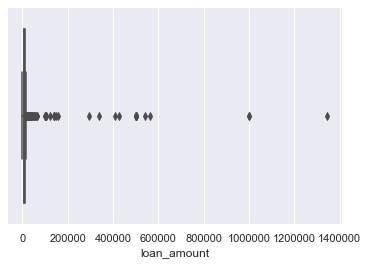

In [595]:
sns.boxplot(data.loan_amount);

count    3.999500e+04
mean     7.959074e-17
std      1.000013e+00
min     -6.113603e-01
25%     -2.510014e-01
50%     -3.037359e-02
75%      1.167116e-01
max      9.814902e+01
Name: loan_amount, dtype: float64


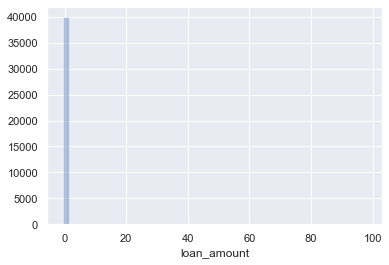

In [596]:
mu = np.mean(data.loan_amount)
std = np.std(data.loan_amount)
zscore = (data.loan_amount - mu)/std
print(zscore.describe())
sns.distplot(zscore,kde=False);

In [ ]:
np.sum(zscore>4)

#### Keep only those training examples for which the loan amount z-score < 5

In [598]:
data = data.loc[zscore[zscore<5].index, :]

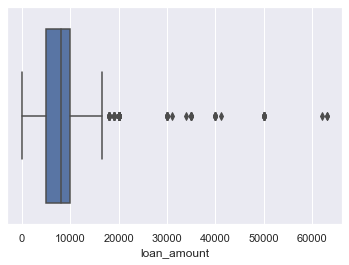

In [599]:
sns.boxplot(data.loan_amount);

### Train-test split
- To prevent target leakage, I'll first split the train and test sets before imputing missing values and target encoding.

In [600]:
datacp = data.copy()
X = data.drop(['Id', 'social_class', 'loan_amount'], axis=1)
y = data['loan_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 9999)

## Missing values

In [601]:
data.isna().sum()

Id                           0
city                         0
sex                          0
social_class                 0
primary_business             0
secondary_business        5236
old_dependents               0
young_dependents             0
home_ownership             379
type_of_house              694
occupants_count              0
house_area                   0
loan_purpose                 0
loan_tenure                  0
loan_installments            0
loan_amount                  0
annual_savings             120
age_group                    0
inc_by_dep                   0
san_water_availability    5248
dtype: int64

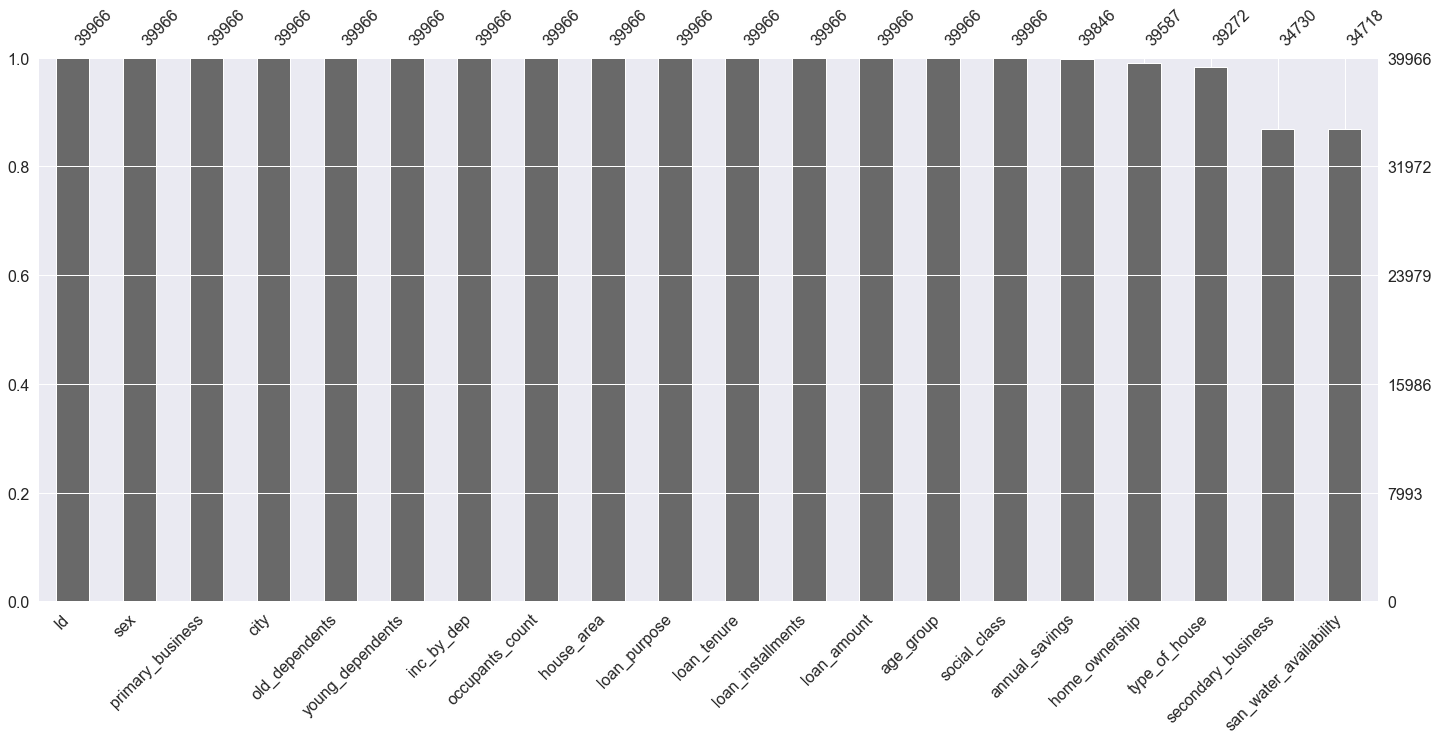

In [602]:
msno.bar(data, sort='descending'); 

### Impute missing values

In [603]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

X_train.loc[:,'annual_savings'] = mean_imp.fit_transform(X_train.loc[:,'annual_savings'].values.reshape(-1,1))
X_test.loc[:,'annual_savings'] = mean_imp.transform(X_test.loc[:,'annual_savings'].values.reshape(-1,1))


X_train.loc[:,'city'] = mode_imp.fit_transform(X_train.loc[:,'city'].values.reshape(-1,1))
X_test.loc[:,'city'] = mode_imp.transform(X_test.loc[:,'city'].values.reshape(-1,1))


X_train.loc[:,'home_ownership'] = mode_imp.fit_transform(X_train.loc[:,'home_ownership'].values.reshape(-1,1))
X_test.loc[:,'home_ownership'] = mode_imp.transform(X_test.loc[:,'home_ownership'].values.reshape(-1,1))

X_train.loc[:,'type_of_house'] = mode_imp.fit_transform(X_train.loc[:,'type_of_house'].values.reshape(-1,1))
X_test.loc[:,'type_of_house'] = mode_imp.transform(X_test.loc[:,'type_of_house'].values.reshape(-1,1))

X_train.loc[:,'secondary_business'] = mode_imp.fit_transform(X_train.loc[:,'secondary_business'].values.reshape(-1,1))
X_test.loc[:,'secondary_business'] = mode_imp.transform(X_test.loc[:,'secondary_business'].values.reshape(-1,1))


X_train.loc[:,'san_water_availability'] = mode_imp.fit_transform(X_train.loc[:,'san_water_availability'].values.reshape(-1,1))
X_test.loc[:,'san_water_availability'] = mode_imp.transform(X_test.loc[:,'san_water_availability'].values.reshape(-1,1))

/Users/debashis/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/debashis/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/debashis/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [604]:
# Catboost

In [605]:
params_cb = {}
params_cb['random_seed'] = 420
params_cb['n_estimators']=200
params_cb['depth']=6
params_cb['reg_lambda'] = 3
params_cb['subsample'] = 0.8
params_cb['cat_features'] = ['sex', 'city', 'primary_business','secondary_business','type_of_house', 'loan_purpose']
cb = CatBoostRegressor(**params_cb)


cb.fit(X_train,y_train)

0:	learn: 3193.7102681	total: 47ms	remaining: 9.36s
1:	learn: 3160.6339445	total: 88.7ms	remaining: 8.78s
2:	learn: 3128.5537685	total: 127ms	remaining: 8.33s
3:	learn: 3099.4759436	total: 159ms	remaining: 7.77s
4:	learn: 3070.8756578	total: 190ms	remaining: 7.4s
5:	learn: 3043.7876243	total: 224ms	remaining: 7.25s
6:	learn: 3016.3319942	total: 260ms	remaining: 7.18s
7:	learn: 2990.6144435	total: 297ms	remaining: 7.14s
8:	learn: 2966.1095147	total: 324ms	remaining: 6.87s
9:	learn: 2942.6285972	total: 350ms	remaining: 6.64s
10:	learn: 2920.6554269	total: 371ms	remaining: 6.38s
11:	learn: 2900.9422339	total: 398ms	remaining: 6.24s
12:	learn: 2880.4261419	total: 423ms	remaining: 6.09s
13:	learn: 2860.9040370	total: 451ms	remaining: 6s
14:	learn: 2843.5495677	total: 502ms	remaining: 6.19s
15:	learn: 2824.8447991	total: 533ms	remaining: 6.13s
16:	learn: 2808.4697594	total: 559ms	remaining: 6.01s
17:	learn: 2792.6490717	total: 585ms	remaining: 5.91s
18:	learn: 2776.8580626	total: 609ms	remai

160:	learn: 2273.3616817	total: 5s	remaining: 1.21s
161:	learn: 2272.9541827	total: 5.03s	remaining: 1.18s
162:	learn: 2271.3368344	total: 5.05s	remaining: 1.15s
163:	learn: 2270.8410945	total: 5.08s	remaining: 1.11s
164:	learn: 2268.9792339	total: 5.11s	remaining: 1.08s
165:	learn: 2268.3634888	total: 5.14s	remaining: 1.05s
166:	learn: 2267.7190924	total: 5.17s	remaining: 1.02s
167:	learn: 2266.1790588	total: 5.19s	remaining: 989ms
168:	learn: 2265.4415174	total: 5.23s	remaining: 960ms
169:	learn: 2265.1428505	total: 5.26s	remaining: 928ms
170:	learn: 2264.9991104	total: 5.28s	remaining: 896ms
171:	learn: 2264.9450778	total: 5.29s	remaining: 862ms
172:	learn: 2263.8949738	total: 5.32s	remaining: 831ms
173:	learn: 2262.4346135	total: 5.34s	remaining: 799ms
174:	learn: 2260.3304830	total: 5.37s	remaining: 767ms
175:	learn: 2260.1982677	total: 5.39s	remaining: 735ms
176:	learn: 2260.1400423	total: 5.41s	remaining: 703ms
177:	learn: 2259.7486936	total: 5.43s	remaining: 671ms
178:	learn: 2

In [606]:
ypred_cb = cb.predict(X_test)
np.sqrt(mse(y_test,ypred_cb))

2323.2313418343756

In [607]:
cv_cb = cross_val_score(cb, X_train, y_train, cv=5,  scoring= 'neg_root_mean_squared_error')
print('Mean CV score: {} and std. dev.: {}'.format(np.mean(np.abs(cv_cb)), np.std(np.abs(cv_cb))))

0:	learn: 3181.1868948	total: 21.4ms	remaining: 4.26s
1:	learn: 3151.5070808	total: 44.1ms	remaining: 4.37s
2:	learn: 3120.8728685	total: 66.7ms	remaining: 4.38s
3:	learn: 3091.3019056	total: 84.2ms	remaining: 4.12s
4:	learn: 3063.1350922	total: 106ms	remaining: 4.13s
5:	learn: 3036.3389885	total: 120ms	remaining: 3.89s
6:	learn: 3008.3026385	total: 140ms	remaining: 3.86s
7:	learn: 2983.7869601	total: 160ms	remaining: 3.85s
8:	learn: 2960.6806377	total: 174ms	remaining: 3.7s
9:	learn: 2938.3637869	total: 195ms	remaining: 3.71s
10:	learn: 2916.8848395	total: 216ms	remaining: 3.7s
11:	learn: 2899.5130400	total: 256ms	remaining: 4s
12:	learn: 2877.9033266	total: 273ms	remaining: 3.93s
13:	learn: 2858.2555608	total: 298ms	remaining: 3.95s
14:	learn: 2840.8014182	total: 313ms	remaining: 3.86s
15:	learn: 2823.5965563	total: 329ms	remaining: 3.78s
16:	learn: 2807.7080597	total: 353ms	remaining: 3.8s
17:	learn: 2792.6078686	total: 368ms	remaining: 3.72s
18:	learn: 2776.2885630	total: 386ms	rem

161:	learn: 2303.8174432	total: 3.3s	remaining: 774ms
162:	learn: 2302.7972816	total: 3.32s	remaining: 754ms
163:	learn: 2302.7344162	total: 3.34s	remaining: 734ms
164:	learn: 2301.4732744	total: 3.36s	remaining: 713ms
165:	learn: 2300.8256487	total: 3.38s	remaining: 693ms
166:	learn: 2300.1958111	total: 3.4s	remaining: 672ms
167:	learn: 2299.3301001	total: 3.42s	remaining: 651ms
168:	learn: 2298.7947739	total: 3.44s	remaining: 631ms
169:	learn: 2296.8769250	total: 3.46s	remaining: 610ms
170:	learn: 2296.2151100	total: 3.48s	remaining: 590ms
171:	learn: 2295.0173172	total: 3.5s	remaining: 570ms
172:	learn: 2294.5792296	total: 3.53s	remaining: 551ms
173:	learn: 2293.1914688	total: 3.55s	remaining: 530ms
174:	learn: 2292.9090738	total: 3.57s	remaining: 510ms
175:	learn: 2289.4551633	total: 3.59s	remaining: 490ms
176:	learn: 2289.2734716	total: 3.61s	remaining: 469ms
177:	learn: 2289.2021539	total: 3.63s	remaining: 449ms
178:	learn: 2288.3496449	total: 3.65s	remaining: 428ms
179:	learn: 2

118:	learn: 2323.6461497	total: 2.4s	remaining: 1.63s
119:	learn: 2322.7231015	total: 2.42s	remaining: 1.61s
120:	learn: 2321.1031519	total: 2.44s	remaining: 1.6s
121:	learn: 2318.9311602	total: 2.46s	remaining: 1.57s
122:	learn: 2317.9944500	total: 2.49s	remaining: 1.56s
123:	learn: 2317.7396226	total: 2.51s	remaining: 1.54s
124:	learn: 2315.8715478	total: 2.54s	remaining: 1.52s
125:	learn: 2314.0555611	total: 2.57s	remaining: 1.51s
126:	learn: 2313.3352357	total: 2.6s	remaining: 1.49s
127:	learn: 2311.2268629	total: 2.64s	remaining: 1.49s
128:	learn: 2308.7040704	total: 2.69s	remaining: 1.48s
129:	learn: 2306.7586033	total: 2.73s	remaining: 1.47s
130:	learn: 2305.1659722	total: 2.77s	remaining: 1.46s
131:	learn: 2303.7062037	total: 2.79s	remaining: 1.44s
132:	learn: 2302.0554646	total: 2.83s	remaining: 1.43s
133:	learn: 2301.5294333	total: 2.85s	remaining: 1.41s
134:	learn: 2299.9312341	total: 2.88s	remaining: 1.38s
135:	learn: 2298.9951134	total: 2.89s	remaining: 1.36s
136:	learn: 2

76:	learn: 2409.7315813	total: 1.74s	remaining: 2.78s
77:	learn: 2406.9989303	total: 1.77s	remaining: 2.77s
78:	learn: 2405.7089264	total: 1.78s	remaining: 2.73s
79:	learn: 2403.7583557	total: 1.81s	remaining: 2.72s
80:	learn: 2401.4059551	total: 1.83s	remaining: 2.69s
81:	learn: 2398.1415575	total: 1.85s	remaining: 2.67s
82:	learn: 2396.2377334	total: 1.88s	remaining: 2.64s
83:	learn: 2393.3273276	total: 1.89s	remaining: 2.62s
84:	learn: 2391.6055956	total: 1.92s	remaining: 2.59s
85:	learn: 2389.8454894	total: 1.93s	remaining: 2.56s
86:	learn: 2388.2958253	total: 1.96s	remaining: 2.55s
87:	learn: 2385.3937380	total: 1.98s	remaining: 2.52s
88:	learn: 2383.5410431	total: 2s	remaining: 2.5s
89:	learn: 2382.7702060	total: 2.02s	remaining: 2.47s
90:	learn: 2381.0525125	total: 2.04s	remaining: 2.44s
91:	learn: 2378.9269953	total: 2.06s	remaining: 2.42s
92:	learn: 2378.1882914	total: 2.08s	remaining: 2.39s
93:	learn: 2376.1753994	total: 2.1s	remaining: 2.36s
94:	learn: 2373.3221379	total: 2.

27:	learn: 2708.3692754	total: 675ms	remaining: 4.14s
28:	learn: 2698.4686640	total: 690ms	remaining: 4.07s
29:	learn: 2689.3769491	total: 705ms	remaining: 4s
30:	learn: 2679.0875932	total: 727ms	remaining: 3.96s
31:	learn: 2670.1885369	total: 743ms	remaining: 3.9s
32:	learn: 2660.2510543	total: 761ms	remaining: 3.85s
33:	learn: 2651.2809744	total: 780ms	remaining: 3.81s
34:	learn: 2642.2396675	total: 796ms	remaining: 3.75s
35:	learn: 2634.9473027	total: 814ms	remaining: 3.71s
36:	learn: 2624.9831217	total: 833ms	remaining: 3.67s
37:	learn: 2617.7976969	total: 850ms	remaining: 3.62s
38:	learn: 2611.2229498	total: 874ms	remaining: 3.61s
39:	learn: 2603.9132088	total: 901ms	remaining: 3.6s
40:	learn: 2596.9794725	total: 924ms	remaining: 3.58s
41:	learn: 2590.4471424	total: 941ms	remaining: 3.54s
42:	learn: 2583.6923865	total: 965ms	remaining: 3.52s
43:	learn: 2576.7682159	total: 984ms	remaining: 3.49s
44:	learn: 2570.1326478	total: 1s	remaining: 3.44s
45:	learn: 2565.6026696	total: 1.02s

189:	learn: 2269.8925752	total: 4.04s	remaining: 213ms
190:	learn: 2269.2715362	total: 4.07s	remaining: 192ms
191:	learn: 2268.7462132	total: 4.08s	remaining: 170ms
192:	learn: 2267.6977847	total: 4.1s	remaining: 149ms
193:	learn: 2267.3800320	total: 4.12s	remaining: 128ms
194:	learn: 2267.0877408	total: 4.14s	remaining: 106ms
195:	learn: 2266.4234374	total: 4.16s	remaining: 84.9ms
196:	learn: 2265.6830163	total: 4.18s	remaining: 63.7ms
197:	learn: 2265.5439452	total: 4.19s	remaining: 42.4ms
198:	learn: 2264.5601755	total: 4.22s	remaining: 21.2ms
199:	learn: 2262.6307289	total: 4.24s	remaining: 0us
0:	learn: 3172.5435830	total: 21.4ms	remaining: 4.25s
1:	learn: 3143.2214225	total: 44.6ms	remaining: 4.41s
2:	learn: 3112.5610021	total: 62.6ms	remaining: 4.11s
3:	learn: 3082.8548482	total: 83.8ms	remaining: 4.11s
4:	learn: 3053.9047202	total: 99.9ms	remaining: 3.9s
5:	learn: 3027.2426572	total: 115ms	remaining: 3.73s
6:	learn: 3001.3468804	total: 141ms	remaining: 3.88s
7:	learn: 2977.3271

152:	learn: 2305.4605753	total: 3.04s	remaining: 936ms
153:	learn: 2303.7866706	total: 3.08s	remaining: 920ms
154:	learn: 2302.9077643	total: 3.1s	remaining: 901ms
155:	learn: 2301.7480364	total: 3.12s	remaining: 881ms
156:	learn: 2300.8276088	total: 3.15s	remaining: 862ms
157:	learn: 2300.7132289	total: 3.15s	remaining: 839ms
158:	learn: 2300.0553396	total: 3.17s	remaining: 817ms
159:	learn: 2298.5355794	total: 3.19s	remaining: 799ms
160:	learn: 2297.6087660	total: 3.21s	remaining: 778ms
161:	learn: 2295.9789173	total: 3.23s	remaining: 758ms
162:	learn: 2295.7435704	total: 3.26s	remaining: 739ms
163:	learn: 2295.6573162	total: 3.27s	remaining: 718ms
164:	learn: 2293.1788881	total: 3.29s	remaining: 699ms
165:	learn: 2292.3598228	total: 3.31s	remaining: 678ms
166:	learn: 2292.3085738	total: 3.33s	remaining: 658ms
167:	learn: 2291.5249202	total: 3.35s	remaining: 638ms
168:	learn: 2289.8549321	total: 3.37s	remaining: 617ms
169:	learn: 2288.2147185	total: 3.39s	remaining: 598ms
170:	learn:

### Encoding categorical variables

In [608]:
tg_encoder1 = ce.target_encoder.TargetEncoder(smoothing=10)
tg_encoder2 = ce.target_encoder.TargetEncoder(smoothing=100)
tg_encoder3 = ce.target_encoder.TargetEncoder(smoothing=100)


tg_encoder1.fit(X_train.city, y_train)
X_train['city_encoded'] = tg_encoder1.transform(X_train.loc[:,'city'])
X_test['city_encoded'] = tg_encoder1.transform(X_test.loc[:,'city'])

tg_encoder2.fit(X_train.primary_business, y_train)
X_train['primary_business_encoded'] = tg_encoder2.transform(X_train.loc[:,'primary_business'])
X_test['primary_business_encoded'] = tg_encoder2.transform(X_test.loc[:,'primary_business'])


tg_encoder3.fit(X_train.loan_purpose, y_train)
X_train['loan_purpose_encoded'] = tg_encoder3.transform(X_train.loc[:,'loan_purpose'])
X_test['loan_purpose_encoded'] = tg_encoder3.transform(X_test.loc[:,'loan_purpose'])

/Users/debashis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/debashis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/debashis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [609]:
X_train = X_train.drop(['primary_business', 'city', 'loan_purpose'], axis=1)
X_test = X_test.drop(['primary_business', 'city', 'loan_purpose'], axis=1)

In [610]:
print('No. of missing values in the train set = {}'.format(X_train.isna().sum().sum()))
print('No. of missing values in the test set = {}'.format(X_test.isna().sum().sum()))

No. of missing values in the train set = 0
No. of missing values in the test set = 0


In [611]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [612]:
print(X_train.shape)
print(X_test.shape)

(27976, 25)
(11990, 25)


In [613]:
X_train.head()

,old_dependents,young_dependents,home_ownership,occupants_count,house_area,loan_tenure,loan_installments,annual_savings,age_group,inc_by_dep,...,sex_M,sex_TG,secondary_business_Agriculture,secondary_business_Daily wage labourer,secondary_business_Livestock rearing,secondary_business_Others,secondary_business_none,type_of_house_R,type_of_house_T1,type_of_house_T2
36863,0,2,1.0,4,1600.0,12,12,33000.0,1,17000.0,...,1,0,0,0,0,0,1,0,0,1
27093,0,0,1.0,4,600.0,12,12,7000.0,3,55000.0,...,1,0,0,0,0,0,1,0,0,1
29469,1,0,1.0,4,1400.0,12,12,12000.0,4,24000.0,...,0,0,0,0,0,0,1,0,0,1
39343,1,0,1.0,3,400.0,6,6,7004.0,2,29500.0,...,0,0,0,0,0,0,1,0,1,0
32083,0,2,1.0,4,600.0,12,12,0.0,2,20000.0,...,0,0,1,0,0,0,0,0,1,0


## Feature selection and modelling

### LASSO
- Standardize the input features for the linear regression models. 
- For tree-based models, I will use non-standardised features.

In [614]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [671]:
def rmse(ytrue, ypred):
    return np.sqrt(mse(ytrue, ypred))

In [615]:
alpha_list_lasso = [1, 2, 5, 8, 10,15, 20]
lasso_model = LassoCV(alphas= alpha_list_lasso, cv=5, random_state=101,max_iter=1e5,)
lasso_model.fit(X_train_sc, y_train)

print("Best alpha using built-in LassoCV: %f" % lasso_model.alpha_)

coef = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 8.000000
Lasso picked 19 variables and eliminated the other 6 variables


#### Feature importance: LASSO

In [616]:
coef[coef != 0].reset_index()

,index,0
0,old_dependents,140.780679
1,young_dependents,339.342361
2,home_ownership,-10.382913
3,occupants_count,160.152582
4,loan_tenure,593.011138
5,annual_savings,98.116643
6,age_group,37.877081
7,inc_by_dep,668.593285
8,san_water_availability,0.132081
9,city_encoded,1241.796355


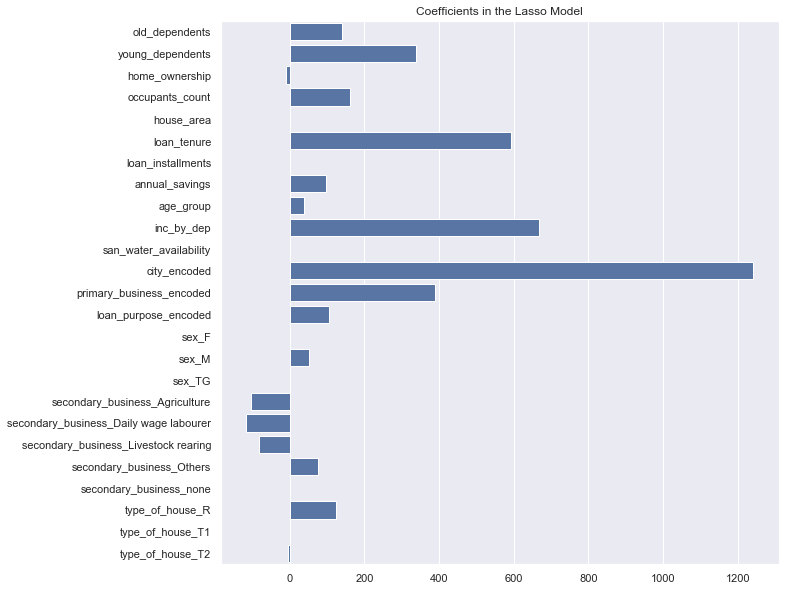

In [617]:
sns.set()
plt.figure(figsize=(10,10))
sns.barplot(coef.values, coef.index,  orient='h',color='b');
plt.title("Coefficients in the Lasso Model");

In [709]:
cv_scores_lasso = cross_val_score(lasso_model,
                                  pd.DataFrame(X_train_sc, columns=X_train.columns)[['city_encoded', 'inc_by_dep',
                                 'loan_tenure', 'primary_business_encoded', 'young_dependents'
                         ]], y_train, cv=5, scoring='neg_root_mean_squared_error' )

print('Mean CV score: {} and std. dev.: {}'.format(np.mean(np.abs(cv_scores_lasso)), np.std(np.abs(cv_scores_lasso))))

Mean CV score: 2573.4894789704936 and std. dev.: 44.639071374963386


### Select K-Best (feature selection)

In [619]:
fs = SelectKBest(score_func=f_regression)
X_fs = fs.fit_transform(X_train, y_train)
pd.DataFrame({'Score':fs.scores_, 'Feature': X_train.columns, 'p-val': fs.pvalues_}).sort_values(by='Score', ascending=False)[:50]

,Score,Feature,p-val
11,9576.273003,city_encoded,0.000000e+00
12,4799.677504,primary_business_encoded,0.000000e+00
9,1889.525799,inc_by_dep,0.000000e+00
13,1612.238772,loan_purpose_encoded,0.000000e+00
3,1398.328937,occupants_count,1.100085e-298
5,1365.368864,loan_tenure,7.355944e-292
7,896.151659,annual_savings,7.712786e-194
6,426.588440,loan_installments,4.527951e-94
1,401.164119,young_dependents,1.286230e-88
18,241.616890,secondary_business_Daily wage labourer,2.946491e-54


#### Which are the most important features according to F-value?

- City
- Primary business
- Annual income to dependents ratio
- Loan purpose
- Occupants count
- Loan tenure

### Random Forest

In [620]:
rfmodel = RandomForestRegressor(n_estimators=200,n_jobs=-1, max_depth = 8, min_samples_split=3,
                               oob_score=True, max_features= 0.8, random_state= 101)
rfmodel.fit(X_train,y_train)
print('RMSE of training set: {}'.format(np.sqrt(mse(y_train, rfmodel.predict(X_train)))))

RMSE of training set: 2139.0441168909706


In [621]:
cv_sc_rf = cross_val_score(rfmodel, X_train, y_train, cv=5,  scoring= 'neg_root_mean_squared_error')
print('Mean CV score: {} and std. dev.: {}'.format(np.mean(np.abs(cv_sc_rf)), np.std(np.abs(cv_sc_rf))))

Mean CV score: 2223.3362389657714 and std. dev.: 39.98777973453077


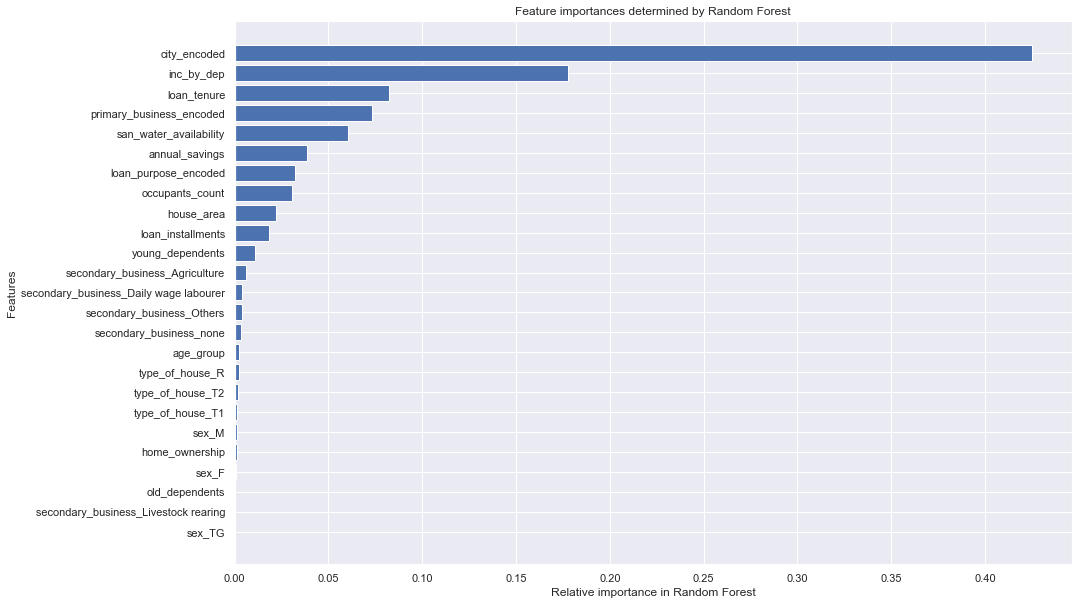

In [622]:
rf_imp_df = pd.DataFrame({'feature_imp':rfmodel.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False)#.iloc[:20]
plt.figure(figsize=(15,10))
plt.barh(rf_imp_df['Feature_name'][::-1],rf_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Relative importance in Random Forest')
plt.ylabel('Features')
plt.title('Feature importances determined by Random Forest')
plt.show()

#### Which are the most important features determined by Random Forest?

- City
- Annual income to dependent ratio
- Primary business
- house area
- Annual savings

In [757]:
imp_feats = ['city_encoded', 'inc_by_dep', 'primary_business_encoded', 'loan_tenure',
                         'loan_purpose_encoded', 'occupants_count']

rfmodel_fs = RandomForestRegressor(n_estimators=150,n_jobs=-1, max_depth = 10, min_samples_split=5,
                                random_state= 101, max_features= 0.5)
rfmodel_fs.fit(Xtrain_rf_fs, y_train)
print("Training set RMSE: {}".format(rmse(y_train, rfmodel_fs.predict(X_train[imp_feats]))))

cv_rf_fs = cross_val_score(rfmodel_fs, Xtrain_rf_fs, y_train, cv=5,  scoring= 'neg_root_mean_squared_error')
print('Mean CV score: {} and std. dev.: {}'.format(np.mean(np.abs(cv_rf_fs)), np.std(np.abs(cv_rf_fs))))

print("Training set RMSE: {}".format(rmse(y_test, rfmodel_fs.predict(X_test[imp_feats]))))

Training set RMSE: 2172.593368113051
Mean CV score: 2266.681365686322 and std. dev.: 36.695903540107984
Training set RMSE: 2321.021164767361


- CV scores improved after feature selection.

#### Grid search: Random forest

In [665]:
def grid_search(reg, parameters, X, y, n_jobs= -1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(reg, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(reg, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds [RMSE]: ",abs(gs.cv_results_['mean_test_score']))
    print ("\nBest parameter set", gs.best_params_, "Corresponding mean CV score (rmse)",abs(gs.best_score_))
    best = gs.best_estimator_
    return best

In [758]:
param = {}
param['n_estimators'] = [100, 150,200]
param['max_depth'] =  [6, 8, 10]
param['max_features'] = ['auto', 'sqrt', 0.6, 0.8]
param['min_samples_split']= [3,5]
param['n_jobs']= [-1]
param['random_state']= [3434]

rf = RandomForestRegressor(**param)

rf_gs  = grid_search(rf, param, Xtrain_rf_fs,y_train, n_folds=5, score_func = 'neg_root_mean_squared_error')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.8min finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [2422.10762718 2422.41736434 2424.14494469 2422.13184643 2422.48828664
 2424.22429616 2436.33302689 2437.87077466 2438.78293497 2435.86956675
 2437.94261919 2438.44844287 2418.42440128 2420.65289577 2420.15081134
 2419.74565324 2421.79242046 2421.3120314  2417.56803755 2418.37703264
 2419.65807503 2418.00720411 2418.44346906 2419.29074898 2336.06426639
 2336.70410046 2338.85181799 2337.15003921 2337.82208666 2339.61970787
 2348.4760705  2349.37968811 2348.64915518 2351.02089555 2351.77637369
 2351.75394004 2331.73996506 2331.54144214 2331.60277302 2333.4882452
 2332.51477349 2333.08197881 2328.95282817 2330.90309855 2331.93882556
 2329.68112226 2331.08339559 2332.43100896 2265.91473978 2267.65819293
 2268.24612481 2267.94264576 2269.61005488 2270.37925013 2274.58655983
 2278.1120439  2278.73041033 2283.18595522 2284.27858414 2283.18571762
 2262.37973283 2264.32531799 2264.23586737 2267.21859205 2268.31474515
 2268.73383979 

In [759]:
print('Train set rmse: {}'.format(rmse(y_train,rf_gs.predict(Xtrain_rf_fs))))
print('Test set rmse: {}'.format(rmse(y_test,rf_gs.predict(Xtest_rf_fs))))

Train set rmse: 2159.8507615651247
Test set rmse: 2316.8985636273487


### XGBoost

In [768]:
param = {}
param['learning_rate'] = 0.3
param['reg_lambda']= 5
param['max_depth'] = 2
param['n_estimators'] = 100
param['random_state']= 777
xgb= XGBRegressor(**param)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state = 43)
xgb.fit(X_train2, y_train2, eval_metric=['rmse'], eval_set=[(X_train2, y_train2),(X_val, y_val)], early_stopping_rounds = 20)

[09:55:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6438.91	validation_1-rmse:6472.95
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:4906.79	validation_1-rmse:4935.78
[2]	validation_0-rmse:3930.87	validation_1-rmse:3963.07
[3]	validation_0-rmse:3324.4	validation_1-rmse:3349.79
[4]	validation_0-rmse:2963.09	validation_1-rmse:2987.19
[5]	validation_0-rmse:2761.22	validation_1-rmse:2789.81
[6]	validation_0-rmse:2640.55	validation_1-rmse:2670.02
[7]	validation_0-rmse:2571.92	validation_1-rmse:2613.41
[8]	validation_0-rmse:2524.1	validation_1-rmse:2576.27
[9]	validation_0-rmse:2492.42	validation_1-rmse:2542.07
[10]	validation_0-rmse:2474.73	validation_1-rmse:2519.77
[11]	validation_0-rmse:2461.71	validation_1-rmse:250

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=777,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

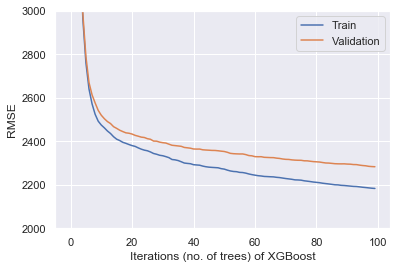

In [769]:
rmse_xgb_df = pd.DataFrame(zip(XGBRegressor.evals_result(xgb)['validation_0']['rmse'], XGBRegressor.evals_result(xgb)['validation_1']['rmse']), columns=['train_rmse', 'dev_rmse'])
sns.lineplot(rmse_xgb_df.index, rmse_xgb_df.train_rmse, label = 'Train');
sns.lineplot(rmse_xgb_df.index, rmse_xgb_df.dev_rmse, label = 'Validation');
plt.ylabel('RMSE');
plt.xlabel('Iterations (no. of trees) of XGBoost');
plt.legend();
plt.ylim(2e3,3e3);

- There is some overfitting!

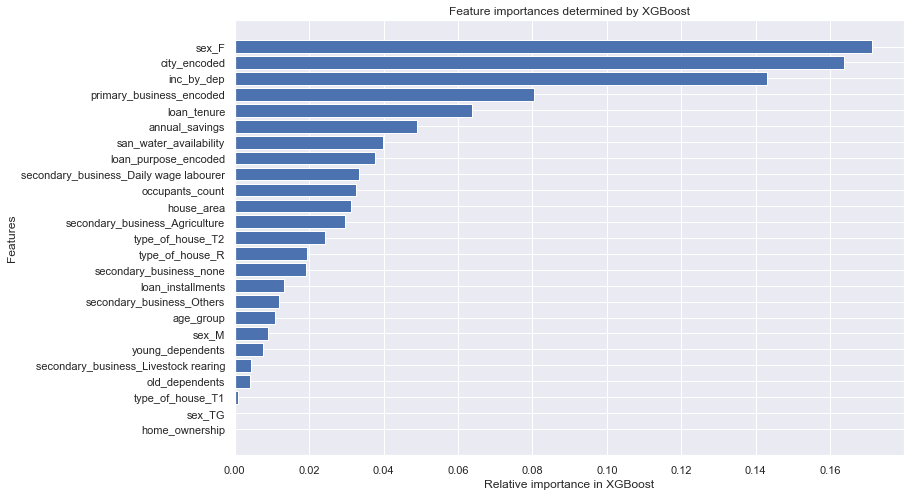

In [676]:
xgb_imp_df = pd.DataFrame({'feature_imp':xgb.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False)
plt.figure(figsize=(12,8))
plt.barh(xgb_imp_df['Feature_name'][::-1],xgb_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Relative importance in XGBoost')
plt.ylabel('Features')
plt.title('Feature importances determined by XGBoost')
plt.show()

In [680]:
param = {}
param['learning_rate'] = 0.3
param['verbosity'] = 1
param['colsample_bytree'] = 0.8
param['subsample'] = 0.8
param['reg_lambda']= 5
param['max_depth'] = 3
param['n_estimators'] = 100
#param['random_state']= 9999

imp_feats = ['city_encoded', 'inc_by_dep', 'primary_business_encoded', 'loan_tenure',
                         'san_water_availability']
xgb_fs= XGBRegressor(objective='reg:linear',**param)
xgb_fs_Xtrain = X_train[imp_feats]
xgb_fs_Xtest = X_test[imp_feats]


X_tr_fs, X_val_fs, y_tr_fs, y_val_fs = train_test_split(xgb_fs_Xtrain, y_train, test_size=0.2, random_state = 11)


xgb_fs.fit(X_tr_fs, y_tr_fs, eval_metric=['rmse'], eval_set=[(X_tr_fs, y_tr_fs),(X_val_fs, y_val_fs)],
          early_stopping_rounds=30)

[19:39:35] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6435.74	validation_1-rmse:6463.73
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:4878.92	validation_1-rmse:4924.07
[2]	validation_0-rmse:3865.09	validation_1-rmse:3925.62


/Users/debashis/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[3]	validation_0-rmse:3259.84	validation_1-rmse:3335.82
[4]	validation_0-rmse:2882.47	validation_1-rmse:2971.53
[5]	validation_0-rmse:2676.48	validation_1-rmse:2777.05
[6]	validation_0-rmse:2555.48	validation_1-rmse:2665.59
[7]	validation_0-rmse:2490.73	validation_1-rmse:2604.95
[8]	validation_0-rmse:2454.46	validation_1-rmse:2571.12
[9]	validation_0-rmse:2421.05	validation_1-rmse:2539.96
[10]	validation_0-rmse:2403.74	validation_1-rmse:2530.38
[11]	validation_0-rmse:2391.19	validation_1-rmse:2518.83
[12]	validation_0-rmse:2382.87	validation_1-rmse:2514.51
[13]	validation_0-rmse:2373.7	validation_1-rmse:2508.57
[14]	validation_0-rmse:2366.34	validation_1-rmse:2501.4
[15]	validation_0-rmse:2361.73	validation_1-rmse:2496.83
[16]	validation_0-rmse:2358.03	validation_1-rmse:2492.47
[17]	validation_0-rmse:2353.77	validation_1-rmse:2490.51
[18]	validation_0-rmse:2348.62	validation_1-rmse:2487.03
[19]	validation_0-rmse:2341.37	validation_1-rmse:2485.71
[20]	validation_0-rmse:2338.64	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

#### Randomized search: XGBoost

In [770]:
param = {}
param['learning_rate'] = [0.1,0.2,0.3]
param['colsample_bytree'] =[ 0.6,0.8, 1.0]
param['subsample'] = [0.6, 0.8, 1.0]
param['reg_lambda']= np.arange(2,6)
param['max_depth'] = [2,3]
param['n_estimators'] = [100,150,200]
param['gamma'] = [0,0.1,0.3,0.5]

clf_xgb_rs = XGBRegressor(objective='reg:squarederror',verbosity= 1, n_jobs = 4)
xgb_gs = RandomizedSearchCV(clf_xgb_rs, param, n_iter = 50, cv=5, scoring='neg_root_mean_squared_error', random_state=101)
import time
print("Randomized search..")
search_time_start = time.time()
xgb_gs.fit(xgb_fs_Xtrain, y_train)
print("Randomized search time: {} mins.".format((time.time() - search_time_start)/60))

print('Best parameter set {}'.format(xgb_gs.best_params_))

Randomized search..
Randomized search time: 3.44166597922643 mins.
Best parameter set {'subsample': 1.0, 'reg_lambda': 5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [772]:
cv_scores_xgb = cross_val_score(xgb_gs, xgb_fs_Xtrain,y_train, cv=5, scoring= 'neg_root_mean_squared_error')
print('Mean CV score: {} and std.: {}'.format(np.mean(np.abs(cv_scores_xgb)),np.std(np.abs(cv_scores_xgb))))

Mean CV score: 2244.828872260647 and std.: 59.332336369558135


In [773]:
#Train set rmse
rmse(y_train, xgb_gs.predict(xgb_fs_Xtrain))

2153.386162105903

### Catboost

In [646]:
cb_reg = CatBoostRegressor(iterations=300,random_seed=33)

In [647]:
validate_pool = Pool(X_test, y_test)
cb_reg.fit(X_train,y_train, eval_set=validate_pool)

0:	learn: 3190.7672935	test: 3313.4654855	best: 3313.4654855 (0)	total: 30.3ms	remaining: 9.06s
1:	learn: 3155.6424781	test: 3278.0449013	best: 3278.0449013 (1)	total: 44.3ms	remaining: 6.6s
2:	learn: 3122.9371259	test: 3244.2899334	best: 3244.2899334 (2)	total: 50.7ms	remaining: 5.02s
3:	learn: 3092.1281773	test: 3212.4009560	best: 3212.4009560 (3)	total: 60.1ms	remaining: 4.45s
4:	learn: 3060.0155382	test: 3178.7519931	best: 3178.7519931 (4)	total: 68.8ms	remaining: 4.06s
5:	learn: 3030.4066577	test: 3147.6838956	best: 3147.6838956 (5)	total: 77ms	remaining: 3.77s
6:	learn: 3002.1445246	test: 3118.3757435	best: 3118.3757435 (6)	total: 83.9ms	remaining: 3.51s
7:	learn: 2975.2928975	test: 3090.7433304	best: 3090.7433304 (7)	total: 88.6ms	remaining: 3.23s
8:	learn: 2951.0496257	test: 3066.1171356	best: 3066.1171356 (8)	total: 93.6ms	remaining: 3.03s
9:	learn: 2926.7284489	test: 3040.7658871	best: 3040.7658871 (9)	total: 101ms	remaining: 2.93s
10:	learn: 2903.5346049	test: 3017.2019338	b

90:	learn: 2330.1380085	test: 2430.8680817	best: 2430.8680817 (90)	total: 822ms	remaining: 1.89s
91:	learn: 2328.7233886	test: 2430.0381089	best: 2430.0381089 (91)	total: 845ms	remaining: 1.91s
92:	learn: 2327.0377667	test: 2428.5635134	best: 2428.5635134 (92)	total: 854ms	remaining: 1.9s
93:	learn: 2325.6429329	test: 2427.3292888	best: 2427.3292888 (93)	total: 859ms	remaining: 1.88s
94:	learn: 2323.9663219	test: 2424.3764280	best: 2424.3764280 (94)	total: 867ms	remaining: 1.87s
95:	learn: 2321.3213251	test: 2421.3802041	best: 2421.3802041 (95)	total: 875ms	remaining: 1.86s
96:	learn: 2320.0090800	test: 2420.5608762	best: 2420.5608762 (96)	total: 883ms	remaining: 1.85s
97:	learn: 2318.9258393	test: 2419.5868695	best: 2419.5868695 (97)	total: 891ms	remaining: 1.84s
98:	learn: 2317.2133413	test: 2417.8690009	best: 2417.8690009 (98)	total: 897ms	remaining: 1.82s
99:	learn: 2315.8132073	test: 2416.7691837	best: 2416.7691837 (99)	total: 902ms	remaining: 1.8s
100:	learn: 2314.5068789	test: 2

179:	learn: 2225.8990800	test: 2331.8042206	best: 2331.8042206 (179)	total: 1.62s	remaining: 1.08s
180:	learn: 2225.2008492	test: 2331.3470769	best: 2331.3470769 (180)	total: 1.65s	remaining: 1.08s
181:	learn: 2224.9922192	test: 2331.1954001	best: 2331.1954001 (181)	total: 1.66s	remaining: 1.07s
182:	learn: 2224.4049633	test: 2329.9973034	best: 2329.9973034 (182)	total: 1.67s	remaining: 1.07s
183:	learn: 2222.9833383	test: 2329.1102125	best: 2329.1102125 (183)	total: 1.72s	remaining: 1.08s
184:	learn: 2221.7541106	test: 2328.2114925	best: 2328.2114925 (184)	total: 1.75s	remaining: 1.09s
185:	learn: 2221.5013812	test: 2328.0229993	best: 2328.0229993 (185)	total: 1.75s	remaining: 1.08s
186:	learn: 2220.3264884	test: 2326.6429747	best: 2326.6429747 (186)	total: 1.76s	remaining: 1.06s
187:	learn: 2219.8841708	test: 2326.4068665	best: 2326.4068665 (187)	total: 1.77s	remaining: 1.05s
188:	learn: 2217.6649738	test: 2324.2652935	best: 2324.2652935 (188)	total: 1.77s	remaining: 1.04s
189:	learn

267:	learn: 2152.5309840	test: 2266.3442188	best: 2266.3441554 (266)	total: 2.44s	remaining: 291ms
268:	learn: 2151.7057958	test: 2265.3234450	best: 2265.3234450 (268)	total: 2.46s	remaining: 284ms
269:	learn: 2150.5310831	test: 2264.0329719	best: 2264.0329719 (269)	total: 2.47s	remaining: 275ms
270:	learn: 2149.9249144	test: 2262.9889189	best: 2262.9889189 (270)	total: 2.48s	remaining: 265ms
271:	learn: 2148.5577948	test: 2261.9658509	best: 2261.9658509 (271)	total: 2.48s	remaining: 256ms
272:	learn: 2148.1275842	test: 2261.4618806	best: 2261.4618806 (272)	total: 2.49s	remaining: 247ms
273:	learn: 2147.8392856	test: 2261.2943158	best: 2261.2943158 (273)	total: 2.5s	remaining: 237ms
274:	learn: 2147.2586593	test: 2260.6655226	best: 2260.6655226 (274)	total: 2.51s	remaining: 228ms
275:	learn: 2146.3083924	test: 2260.0625701	best: 2260.0625701 (275)	total: 2.52s	remaining: 219ms
276:	learn: 2145.6042820	test: 2259.3891554	best: 2259.3891554 (276)	total: 2.53s	remaining: 210ms
277:	learn:

In [648]:
cv_cb = cross_val_score(cb_reg, X_train,y_train,cv=5, scoring='neg_root_mean_squared_error')
print('Mean CV score: {} and std: {}'.format(np.mean(np.abs(cv_cb)), np.std(np.abs(cv_cb))))

0:	learn: 3174.1532139	total: 11.3ms	remaining: 3.39s
1:	learn: 3139.7180989	total: 19.3ms	remaining: 2.88s
2:	learn: 3107.4150736	total: 26.6ms	remaining: 2.63s
3:	learn: 3079.1161234	total: 32.1ms	remaining: 2.37s
4:	learn: 3049.1244366	total: 36.4ms	remaining: 2.15s
5:	learn: 3019.9161672	total: 40.6ms	remaining: 1.99s
6:	learn: 2991.8308036	total: 51ms	remaining: 2.13s
7:	learn: 2964.4485411	total: 71.7ms	remaining: 2.62s
8:	learn: 2939.5031295	total: 78.5ms	remaining: 2.54s
9:	learn: 2915.5821152	total: 87.1ms	remaining: 2.53s
10:	learn: 2892.9360921	total: 91.6ms	remaining: 2.41s
11:	learn: 2871.8346479	total: 98.7ms	remaining: 2.37s
12:	learn: 2850.1426475	total: 106ms	remaining: 2.35s
13:	learn: 2829.1493649	total: 113ms	remaining: 2.32s
14:	learn: 2810.8242249	total: 122ms	remaining: 2.31s
15:	learn: 2792.0798841	total: 128ms	remaining: 2.27s
16:	learn: 2775.7278867	total: 132ms	remaining: 2.2s
17:	learn: 2758.2480145	total: 137ms	remaining: 2.14s
18:	learn: 2742.7527806	total

153:	learn: 2261.7158389	total: 1.82s	remaining: 1.72s
154:	learn: 2260.7108138	total: 1.83s	remaining: 1.72s
155:	learn: 2259.3981680	total: 1.85s	remaining: 1.71s
156:	learn: 2257.2229314	total: 1.86s	remaining: 1.69s
157:	learn: 2256.3313389	total: 1.86s	remaining: 1.67s
158:	learn: 2255.7920795	total: 1.87s	remaining: 1.66s
159:	learn: 2254.5300807	total: 1.87s	remaining: 1.64s
160:	learn: 2252.9239926	total: 1.88s	remaining: 1.63s
161:	learn: 2252.2493767	total: 1.89s	remaining: 1.61s
162:	learn: 2250.9559630	total: 1.9s	remaining: 1.59s
163:	learn: 2249.8731767	total: 1.91s	remaining: 1.58s
164:	learn: 2249.5162217	total: 1.91s	remaining: 1.57s
165:	learn: 2249.1179802	total: 1.94s	remaining: 1.56s
166:	learn: 2248.7820706	total: 1.95s	remaining: 1.55s
167:	learn: 2247.2283611	total: 1.96s	remaining: 1.54s
168:	learn: 2246.9602341	total: 1.97s	remaining: 1.53s
169:	learn: 2245.5006018	total: 2s	remaining: 1.53s
170:	learn: 2244.8851267	total: 2.01s	remaining: 1.52s
171:	learn: 22

15:	learn: 2809.3699011	total: 224ms	remaining: 3.97s
16:	learn: 2792.0635164	total: 237ms	remaining: 3.94s
17:	learn: 2775.1367747	total: 254ms	remaining: 3.98s
18:	learn: 2759.0254993	total: 265ms	remaining: 3.92s
19:	learn: 2741.8160601	total: 273ms	remaining: 3.83s
20:	learn: 2725.8676396	total: 280ms	remaining: 3.71s
21:	learn: 2712.3864499	total: 283ms	remaining: 3.58s
22:	learn: 2697.6724376	total: 292ms	remaining: 3.51s
23:	learn: 2682.8734319	total: 301ms	remaining: 3.46s
24:	learn: 2670.1067042	total: 318ms	remaining: 3.5s
25:	learn: 2658.2544270	total: 329ms	remaining: 3.47s
26:	learn: 2646.7926345	total: 343ms	remaining: 3.46s
27:	learn: 2634.8549747	total: 354ms	remaining: 3.44s
28:	learn: 2624.0202863	total: 362ms	remaining: 3.38s
29:	learn: 2613.5091829	total: 371ms	remaining: 3.34s
30:	learn: 2603.2518350	total: 376ms	remaining: 3.26s
31:	learn: 2593.4063792	total: 383ms	remaining: 3.2s
32:	learn: 2584.5665691	total: 392ms	remaining: 3.17s
33:	learn: 2575.6349815	total:

190:	learn: 2195.1730586	total: 2.06s	remaining: 1.18s
191:	learn: 2194.6450903	total: 2.08s	remaining: 1.17s
192:	learn: 2193.8260548	total: 2.09s	remaining: 1.16s
193:	learn: 2192.0972641	total: 2.1s	remaining: 1.15s
194:	learn: 2190.5758896	total: 2.12s	remaining: 1.14s
195:	learn: 2189.2172720	total: 2.13s	remaining: 1.13s
196:	learn: 2188.2490200	total: 2.15s	remaining: 1.12s
197:	learn: 2186.7330651	total: 2.15s	remaining: 1.11s
198:	learn: 2186.1709311	total: 2.17s	remaining: 1.1s
199:	learn: 2185.0121001	total: 2.18s	remaining: 1.09s
200:	learn: 2184.1930696	total: 2.2s	remaining: 1.08s
201:	learn: 2183.1768903	total: 2.2s	remaining: 1.07s
202:	learn: 2181.1759276	total: 2.22s	remaining: 1.06s
203:	learn: 2180.3191553	total: 2.23s	remaining: 1.05s
204:	learn: 2179.2125075	total: 2.25s	remaining: 1.04s
205:	learn: 2178.8350166	total: 2.25s	remaining: 1.03s
206:	learn: 2178.2913323	total: 2.28s	remaining: 1.02s
207:	learn: 2177.7610854	total: 2.29s	remaining: 1.01s
208:	learn: 21

64:	learn: 2401.2903197	total: 681ms	remaining: 2.46s
65:	learn: 2398.5630682	total: 698ms	remaining: 2.48s
66:	learn: 2395.7579673	total: 705ms	remaining: 2.45s
67:	learn: 2392.4799726	total: 713ms	remaining: 2.43s
68:	learn: 2389.8859825	total: 724ms	remaining: 2.42s
69:	learn: 2384.4346954	total: 728ms	remaining: 2.39s
70:	learn: 2381.7388633	total: 736ms	remaining: 2.37s
71:	learn: 2379.4647766	total: 743ms	remaining: 2.35s
72:	learn: 2377.0954972	total: 750ms	remaining: 2.33s
73:	learn: 2373.5363426	total: 758ms	remaining: 2.31s
74:	learn: 2371.7843586	total: 764ms	remaining: 2.29s
75:	learn: 2369.5365660	total: 768ms	remaining: 2.26s
76:	learn: 2366.8795318	total: 772ms	remaining: 2.24s
77:	learn: 2365.1259471	total: 777ms	remaining: 2.21s
78:	learn: 2363.1660609	total: 783ms	remaining: 2.19s
79:	learn: 2360.7619119	total: 791ms	remaining: 2.17s
80:	learn: 2358.4809237	total: 798ms	remaining: 2.16s
81:	learn: 2356.1206541	total: 805ms	remaining: 2.14s
82:	learn: 2354.1583593	tota

226:	learn: 2183.1944109	total: 2.07s	remaining: 667ms
227:	learn: 2182.2899936	total: 2.08s	remaining: 659ms
228:	learn: 2182.2597556	total: 2.09s	remaining: 648ms
229:	learn: 2181.1440242	total: 2.1s	remaining: 639ms
230:	learn: 2181.0115044	total: 2.1s	remaining: 629ms
231:	learn: 2180.0885822	total: 2.11s	remaining: 618ms
232:	learn: 2179.8256116	total: 2.11s	remaining: 608ms
233:	learn: 2178.6726064	total: 2.12s	remaining: 598ms
234:	learn: 2177.5074052	total: 2.13s	remaining: 588ms
235:	learn: 2177.4788846	total: 2.13s	remaining: 578ms
236:	learn: 2176.8714988	total: 2.15s	remaining: 570ms
237:	learn: 2175.9509027	total: 2.15s	remaining: 561ms
238:	learn: 2174.8467724	total: 2.16s	remaining: 550ms
239:	learn: 2174.4048016	total: 2.16s	remaining: 540ms
240:	learn: 2172.7224621	total: 2.17s	remaining: 530ms
241:	learn: 2171.9250727	total: 2.18s	remaining: 522ms
242:	learn: 2171.4278221	total: 2.19s	remaining: 513ms
243:	learn: 2170.5546416	total: 2.19s	remaining: 504ms
244:	learn: 

81:	learn: 2373.7818503	total: 863ms	remaining: 2.29s
82:	learn: 2371.6225330	total: 878ms	remaining: 2.29s
83:	learn: 2370.0946210	total: 886ms	remaining: 2.28s
84:	learn: 2368.2555320	total: 893ms	remaining: 2.26s
85:	learn: 2364.7369258	total: 901ms	remaining: 2.24s
86:	learn: 2362.5413442	total: 906ms	remaining: 2.22s
87:	learn: 2359.1079443	total: 910ms	remaining: 2.19s
88:	learn: 2357.4108374	total: 914ms	remaining: 2.17s
89:	learn: 2355.1593480	total: 921ms	remaining: 2.15s
90:	learn: 2353.6701001	total: 928ms	remaining: 2.13s
91:	learn: 2352.1490445	total: 934ms	remaining: 2.11s
92:	learn: 2350.2793230	total: 941ms	remaining: 2.1s
93:	learn: 2348.3143255	total: 953ms	remaining: 2.09s
94:	learn: 2346.6268025	total: 957ms	remaining: 2.06s
95:	learn: 2343.8514848	total: 961ms	remaining: 2.04s
96:	learn: 2342.7735285	total: 968ms	remaining: 2.03s
97:	learn: 2341.6130595	total: 976ms	remaining: 2.01s
98:	learn: 2339.9273659	total: 983ms	remaining: 2s
99:	learn: 2337.8663661	total: 9

255:	learn: 2171.1661000	total: 2.28s	remaining: 393ms
256:	learn: 2170.0384517	total: 2.29s	remaining: 383ms
257:	learn: 2169.6079969	total: 2.3s	remaining: 375ms
258:	learn: 2168.5625367	total: 2.32s	remaining: 367ms
259:	learn: 2167.7980664	total: 2.33s	remaining: 358ms
260:	learn: 2166.9632544	total: 2.33s	remaining: 349ms
261:	learn: 2166.4082278	total: 2.34s	remaining: 339ms
262:	learn: 2165.8747461	total: 2.34s	remaining: 330ms
263:	learn: 2164.4991505	total: 2.36s	remaining: 321ms
264:	learn: 2164.3318962	total: 2.36s	remaining: 312ms
265:	learn: 2163.5250462	total: 2.37s	remaining: 303ms
266:	learn: 2162.5938489	total: 2.38s	remaining: 294ms
267:	learn: 2162.1687401	total: 2.38s	remaining: 285ms
268:	learn: 2161.9218266	total: 2.39s	remaining: 275ms
269:	learn: 2161.0999965	total: 2.4s	remaining: 266ms
270:	learn: 2160.8576530	total: 2.4s	remaining: 257ms
271:	learn: 2160.3657792	total: 2.41s	remaining: 248ms
272:	learn: 2159.8095200	total: 2.42s	remaining: 239ms
273:	learn: 2

117:	learn: 2291.6894431	total: 1.05s	remaining: 1.62s
118:	learn: 2290.9373283	total: 1.06s	remaining: 1.62s
119:	learn: 2289.5165625	total: 1.08s	remaining: 1.61s
120:	learn: 2288.5452004	total: 1.08s	remaining: 1.6s
121:	learn: 2288.2874476	total: 1.08s	remaining: 1.58s
122:	learn: 2285.9212459	total: 1.09s	remaining: 1.57s
123:	learn: 2285.2965573	total: 1.09s	remaining: 1.55s
124:	learn: 2284.5039018	total: 1.1s	remaining: 1.54s
125:	learn: 2283.3764463	total: 1.11s	remaining: 1.53s
126:	learn: 2282.2533964	total: 1.12s	remaining: 1.52s
127:	learn: 2281.7534217	total: 1.12s	remaining: 1.51s
128:	learn: 2280.6420632	total: 1.13s	remaining: 1.5s
129:	learn: 2279.6906302	total: 1.13s	remaining: 1.48s
130:	learn: 2278.8457167	total: 1.14s	remaining: 1.47s
131:	learn: 2277.9657808	total: 1.14s	remaining: 1.45s
132:	learn: 2277.3812028	total: 1.15s	remaining: 1.44s
133:	learn: 2276.4426733	total: 1.16s	remaining: 1.43s
134:	learn: 2274.6314894	total: 1.16s	remaining: 1.42s
135:	learn: 2

278:	learn: 2150.8405226	total: 2.28s	remaining: 171ms
279:	learn: 2150.6111291	total: 2.29s	remaining: 164ms
280:	learn: 2149.6537158	total: 2.33s	remaining: 157ms
281:	learn: 2148.2916688	total: 2.33s	remaining: 149ms
282:	learn: 2147.1117116	total: 2.37s	remaining: 142ms
283:	learn: 2146.7190010	total: 2.38s	remaining: 134ms
284:	learn: 2146.6916599	total: 2.39s	remaining: 126ms
285:	learn: 2146.0730297	total: 2.42s	remaining: 118ms
286:	learn: 2145.5167216	total: 2.43s	remaining: 110ms
287:	learn: 2144.4240999	total: 2.45s	remaining: 102ms
288:	learn: 2143.7177471	total: 2.47s	remaining: 94ms
289:	learn: 2143.2080382	total: 2.49s	remaining: 86ms
290:	learn: 2142.6282445	total: 2.51s	remaining: 77.7ms
291:	learn: 2141.6905690	total: 2.53s	remaining: 69.2ms
292:	learn: 2140.5911889	total: 2.56s	remaining: 61.2ms
293:	learn: 2139.6908916	total: 2.57s	remaining: 52.5ms
294:	learn: 2139.4902318	total: 2.59s	remaining: 43.9ms
295:	learn: 2138.3847964	total: 2.61s	remaining: 35.3ms
296:	l

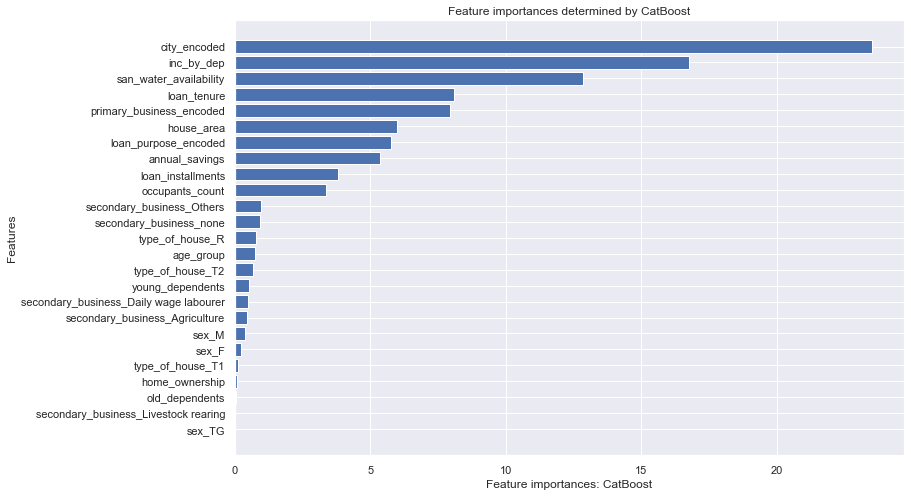

In [650]:
cb_imp_df = pd.DataFrame({'feature_imp':cb_reg.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False)#.iloc[:20]
plt.figure(figsize=(12,8))
plt.barh(cb_imp_df['Feature_name'][::-1],cb_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Feature importances: CatBoost')
plt.ylabel('Features')
plt.title('Feature importances determined by CatBoost')
plt.show()

#### CatBoost with reduced feature set

In [651]:

cb_reg_fs = CatBoostRegressor(iterations=300, random_seed=33,reg_lambda=3, subsample=0.6, 
                             learning_rate=0.2, depth=6)

Xtrain_cb_fs = X_train[['city_encoded', 'inc_by_dep', 'primary_business_encoded', 'loan_tenure',
                         'san_water_availability']]
        
Xtest_cb_fs = X_test[['city_encoded', 'inc_by_dep', 'primary_business_encoded', 'loan_tenure',
                         'san_water_availability']]


#X_train2, X_val, y_train2, y_val = train_test_split(Xtrain_cb_fs, y_train, test_size=0.3, random_state=21212,shuffle=True)

validate_pool = Pool(Xtest_cb_fs, y_test)
# Note that although I'm evaluating on the test set, I'm not using early stopping here, so test set is untouched by the model.
cb_reg_fs.fit(Xtrain_cb_fs,y_train, eval_set=validate_pool)

0:	learn: 2999.7506903	test: 3116.1885108	best: 3116.1885108 (0)	total: 28.2ms	remaining: 8.42s
1:	learn: 2831.5308927	test: 2942.1817712	best: 2942.1817712 (1)	total: 36.3ms	remaining: 5.41s
2:	learn: 2719.0670568	test: 2832.6878577	best: 2832.6878577 (2)	total: 58.8ms	remaining: 5.82s
3:	learn: 2640.2566962	test: 2747.7127547	best: 2747.7127547 (3)	total: 79.6ms	remaining: 5.89s
4:	learn: 2579.9848578	test: 2682.9862225	best: 2682.9862225 (4)	total: 107ms	remaining: 6.32s
5:	learn: 2535.4126309	test: 2631.3576549	best: 2631.3576549 (5)	total: 121ms	remaining: 5.92s
6:	learn: 2502.0928386	test: 2600.1939615	best: 2600.1939615 (6)	total: 127ms	remaining: 5.3s
7:	learn: 2477.6794803	test: 2577.6308443	best: 2577.6308443 (7)	total: 132ms	remaining: 4.82s
8:	learn: 2450.2332834	test: 2543.7347757	best: 2543.7347757 (8)	total: 137ms	remaining: 4.43s
9:	learn: 2433.1628725	test: 2525.6217544	best: 2525.6217544 (9)	total: 144ms	remaining: 4.18s
10:	learn: 2419.2440710	test: 2511.7175453	best

112:	learn: 2154.1124215	test: 2274.8037700	best: 2274.8037700 (112)	total: 799ms	remaining: 1.32s
113:	learn: 2153.5241018	test: 2274.2433427	best: 2274.2433427 (113)	total: 814ms	remaining: 1.33s
114:	learn: 2153.1845698	test: 2273.7560675	best: 2273.7560675 (114)	total: 831ms	remaining: 1.34s
115:	learn: 2151.7069300	test: 2271.7860148	best: 2271.7860148 (115)	total: 835ms	remaining: 1.32s
116:	learn: 2150.3277706	test: 2271.0039833	best: 2271.0039833 (116)	total: 843ms	remaining: 1.32s
117:	learn: 2149.6005024	test: 2270.9076109	best: 2270.9076109 (117)	total: 849ms	remaining: 1.31s
118:	learn: 2148.5450287	test: 2269.9853343	best: 2269.9853343 (118)	total: 857ms	remaining: 1.3s
119:	learn: 2147.4894604	test: 2269.2075298	best: 2269.2075298 (119)	total: 863ms	remaining: 1.29s
120:	learn: 2146.5686658	test: 2268.4774649	best: 2268.4774649 (120)	total: 871ms	remaining: 1.29s
121:	learn: 2144.6484890	test: 2266.3845322	best: 2266.3845322 (121)	total: 881ms	remaining: 1.28s
122:	learn:

200:	learn: 2078.8856108	test: 2228.1870584	best: 2228.1870584 (200)	total: 1.38s	remaining: 678ms
201:	learn: 2078.3357734	test: 2227.7267829	best: 2227.7267829 (201)	total: 1.4s	remaining: 677ms
202:	learn: 2077.1064532	test: 2226.6805658	best: 2226.6805658 (202)	total: 1.4s	remaining: 669ms
203:	learn: 2076.4353136	test: 2226.2016093	best: 2226.2016093 (203)	total: 1.4s	remaining: 660ms
204:	learn: 2075.6793457	test: 2225.6320525	best: 2225.6320525 (204)	total: 1.41s	remaining: 653ms
205:	learn: 2075.0621011	test: 2225.4542000	best: 2225.4542000 (205)	total: 1.42s	remaining: 647ms
206:	learn: 2074.6211867	test: 2224.6299947	best: 2224.6299947 (206)	total: 1.42s	remaining: 640ms
207:	learn: 2074.0676675	test: 2224.2389868	best: 2224.2389868 (207)	total: 1.43s	remaining: 633ms
208:	learn: 2073.5764771	test: 2223.8948336	best: 2223.8948336 (208)	total: 1.44s	remaining: 626ms
209:	learn: 2073.3082370	test: 2223.9037647	best: 2223.8948336 (208)	total: 1.44s	remaining: 619ms
210:	learn: 2

292:	learn: 2031.7300744	test: 2203.3491859	best: 2203.3491859 (292)	total: 1.96s	remaining: 46.8ms
293:	learn: 2031.4089841	test: 2202.9099501	best: 2202.9099501 (293)	total: 1.97s	remaining: 40.1ms
294:	learn: 2030.9751926	test: 2202.8860105	best: 2202.8860105 (294)	total: 1.98s	remaining: 33.5ms
295:	learn: 2030.4307308	test: 2202.6236643	best: 2202.6236643 (295)	total: 1.99s	remaining: 26.9ms
296:	learn: 2029.7314073	test: 2202.4175973	best: 2202.4175973 (296)	total: 1.99s	remaining: 20.1ms
297:	learn: 2029.1006234	test: 2201.8172935	best: 2201.8172935 (297)	total: 2s	remaining: 13.4ms
298:	learn: 2028.7419619	test: 2201.9204922	best: 2201.8172935 (297)	total: 2.01s	remaining: 6.72ms
299:	learn: 2028.4608929	test: 2201.9030022	best: 2201.8172935 (297)	total: 2.01s	remaining: 0us

bestTest = 2201.817294
bestIteration = 297

Shrink model to first 298 iterations.


In [654]:
cvcbfs = np.abs(cross_val_score(cb_reg_fs, Xtrain_cb_fs,y_train,cv=5, scoring='neg_root_mean_squared_error'))

0:	learn: 2985.9964431	total: 16.7ms	remaining: 4.98s
1:	learn: 2820.5264313	total: 23.5ms	remaining: 3.51s
2:	learn: 2712.8352246	total: 38.3ms	remaining: 3.79s
3:	learn: 2628.0863726	total: 56ms	remaining: 4.15s
4:	learn: 2564.2766685	total: 65.3ms	remaining: 3.85s
5:	learn: 2526.6765675	total: 71.5ms	remaining: 3.5s
6:	learn: 2493.1072429	total: 86.7ms	remaining: 3.63s
7:	learn: 2469.2875455	total: 116ms	remaining: 4.24s
8:	learn: 2441.0007364	total: 119ms	remaining: 3.86s
9:	learn: 2424.1621025	total: 123ms	remaining: 3.55s
10:	learn: 2413.6626566	total: 130ms	remaining: 3.42s
11:	learn: 2403.8853409	total: 136ms	remaining: 3.27s
12:	learn: 2389.4988122	total: 142ms	remaining: 3.13s
13:	learn: 2379.6060858	total: 147ms	remaining: 3.01s
14:	learn: 2370.1489359	total: 153ms	remaining: 2.91s
15:	learn: 2361.9291634	total: 159ms	remaining: 2.82s
16:	learn: 2356.5620477	total: 163ms	remaining: 2.71s
17:	learn: 2353.4428769	total: 166ms	remaining: 2.61s
18:	learn: 2349.6727277	total: 171

171:	learn: 2094.5685523	total: 1.21s	remaining: 900ms
172:	learn: 2093.8497220	total: 1.22s	remaining: 897ms
173:	learn: 2092.9044815	total: 1.25s	remaining: 902ms
174:	learn: 2092.2230804	total: 1.25s	remaining: 895ms
175:	learn: 2091.8045558	total: 1.26s	remaining: 888ms
176:	learn: 2091.2949482	total: 1.27s	remaining: 883ms
177:	learn: 2091.0724600	total: 1.28s	remaining: 879ms
178:	learn: 2089.7534743	total: 1.29s	remaining: 874ms
179:	learn: 2089.0049023	total: 1.3s	remaining: 867ms
180:	learn: 2088.4144219	total: 1.31s	remaining: 861ms
181:	learn: 2087.6495899	total: 1.31s	remaining: 852ms
182:	learn: 2086.9491072	total: 1.32s	remaining: 844ms
183:	learn: 2085.7748143	total: 1.33s	remaining: 836ms
184:	learn: 2084.9467091	total: 1.33s	remaining: 828ms
185:	learn: 2084.2705033	total: 1.34s	remaining: 820ms
186:	learn: 2083.7534229	total: 1.34s	remaining: 812ms
187:	learn: 2083.0531692	total: 1.35s	remaining: 803ms
188:	learn: 2082.6358664	total: 1.35s	remaining: 793ms
189:	learn:

47:	learn: 2251.0993526	total: 416ms	remaining: 2.19s
48:	learn: 2248.6149205	total: 433ms	remaining: 2.22s
49:	learn: 2245.3128217	total: 445ms	remaining: 2.23s
50:	learn: 2243.5965820	total: 469ms	remaining: 2.29s
51:	learn: 2241.0009664	total: 477ms	remaining: 2.28s
52:	learn: 2237.3746584	total: 484ms	remaining: 2.26s
53:	learn: 2234.4095397	total: 502ms	remaining: 2.29s
54:	learn: 2231.7145783	total: 517ms	remaining: 2.31s
55:	learn: 2228.7588627	total: 524ms	remaining: 2.28s
56:	learn: 2226.9746143	total: 534ms	remaining: 2.28s
57:	learn: 2224.9737894	total: 543ms	remaining: 2.27s
58:	learn: 2221.7940038	total: 554ms	remaining: 2.26s
59:	learn: 2220.3422622	total: 568ms	remaining: 2.27s
60:	learn: 2217.7716716	total: 575ms	remaining: 2.25s
61:	learn: 2213.9196533	total: 580ms	remaining: 2.23s
62:	learn: 2211.3052233	total: 601ms	remaining: 2.26s
63:	learn: 2208.8501262	total: 618ms	remaining: 2.28s
64:	learn: 2205.1230937	total: 628ms	remaining: 2.27s
65:	learn: 2204.1505285	tota

207:	learn: 2052.3967532	total: 1.81s	remaining: 801ms
208:	learn: 2050.9905405	total: 1.83s	remaining: 797ms
209:	learn: 2050.6680487	total: 1.83s	remaining: 787ms
210:	learn: 2050.3569340	total: 1.84s	remaining: 777ms
211:	learn: 2050.0254357	total: 1.85s	remaining: 768ms
212:	learn: 2049.7457190	total: 1.85s	remaining: 757ms
213:	learn: 2048.1877918	total: 1.86s	remaining: 746ms
214:	learn: 2047.4516102	total: 1.86s	remaining: 736ms
215:	learn: 2047.1385696	total: 1.86s	remaining: 725ms
216:	learn: 2046.9368947	total: 1.87s	remaining: 716ms
217:	learn: 2046.2537504	total: 1.88s	remaining: 706ms
218:	learn: 2045.8473801	total: 1.88s	remaining: 697ms
219:	learn: 2045.0670575	total: 1.89s	remaining: 687ms
220:	learn: 2044.1683010	total: 1.9s	remaining: 678ms
221:	learn: 2043.5587927	total: 1.9s	remaining: 668ms
222:	learn: 2042.9816890	total: 1.91s	remaining: 658ms
223:	learn: 2042.5186679	total: 1.91s	remaining: 648ms
224:	learn: 2042.1845891	total: 1.92s	remaining: 640ms
225:	learn: 

67:	learn: 2209.2855516	total: 404ms	remaining: 1.38s
68:	learn: 2206.9308780	total: 415ms	remaining: 1.39s
69:	learn: 2205.3528659	total: 418ms	remaining: 1.37s
70:	learn: 2203.6711624	total: 422ms	remaining: 1.36s
71:	learn: 2201.3240641	total: 425ms	remaining: 1.35s
72:	learn: 2198.9690610	total: 431ms	remaining: 1.34s
73:	learn: 2197.3255203	total: 436ms	remaining: 1.33s
74:	learn: 2196.4022386	total: 442ms	remaining: 1.32s
75:	learn: 2194.9390121	total: 450ms	remaining: 1.33s
76:	learn: 2193.5535571	total: 458ms	remaining: 1.33s
77:	learn: 2191.7910739	total: 463ms	remaining: 1.32s
78:	learn: 2190.5517188	total: 468ms	remaining: 1.31s
79:	learn: 2189.4723506	total: 471ms	remaining: 1.29s
80:	learn: 2187.8985364	total: 475ms	remaining: 1.28s
81:	learn: 2185.3606065	total: 481ms	remaining: 1.28s
82:	learn: 2182.6339937	total: 487ms	remaining: 1.27s
83:	learn: 2181.8069016	total: 496ms	remaining: 1.27s
84:	learn: 2180.8286083	total: 510ms	remaining: 1.29s
85:	learn: 2179.8223193	tota

227:	learn: 2051.4504621	total: 1.38s	remaining: 436ms
228:	learn: 2050.5880424	total: 1.41s	remaining: 436ms
229:	learn: 2050.3228734	total: 1.41s	remaining: 430ms
230:	learn: 2049.6734362	total: 1.42s	remaining: 423ms
231:	learn: 2049.0996548	total: 1.42s	remaining: 416ms
232:	learn: 2048.4669013	total: 1.42s	remaining: 410ms
233:	learn: 2047.9653896	total: 1.43s	remaining: 403ms
234:	learn: 2046.9203007	total: 1.44s	remaining: 397ms
235:	learn: 2046.4348616	total: 1.44s	remaining: 391ms
236:	learn: 2046.1318930	total: 1.45s	remaining: 385ms
237:	learn: 2045.2818481	total: 1.46s	remaining: 380ms
238:	learn: 2044.8241729	total: 1.46s	remaining: 373ms
239:	learn: 2044.2459371	total: 1.47s	remaining: 367ms
240:	learn: 2043.8789404	total: 1.49s	remaining: 364ms
241:	learn: 2043.4709004	total: 1.5s	remaining: 359ms
242:	learn: 2042.9121784	total: 1.5s	remaining: 353ms
243:	learn: 2042.5267536	total: 1.51s	remaining: 346ms
244:	learn: 2041.9426630	total: 1.51s	remaining: 340ms
245:	learn: 

86:	learn: 2197.9740715	total: 516ms	remaining: 1.26s
87:	learn: 2195.6985891	total: 538ms	remaining: 1.3s
88:	learn: 2194.0166612	total: 546ms	remaining: 1.29s
89:	learn: 2193.0334329	total: 552ms	remaining: 1.29s
90:	learn: 2190.5957062	total: 558ms	remaining: 1.28s
91:	learn: 2189.4860067	total: 565ms	remaining: 1.28s
92:	learn: 2187.8778937	total: 570ms	remaining: 1.27s
93:	learn: 2185.5379126	total: 576ms	remaining: 1.26s
94:	learn: 2184.8024873	total: 579ms	remaining: 1.25s
95:	learn: 2183.4777033	total: 582ms	remaining: 1.24s
96:	learn: 2181.7200683	total: 585ms	remaining: 1.23s
97:	learn: 2180.7480958	total: 589ms	remaining: 1.21s
98:	learn: 2179.6419369	total: 595ms	remaining: 1.21s
99:	learn: 2177.8083743	total: 602ms	remaining: 1.2s
100:	learn: 2176.2782534	total: 607ms	remaining: 1.2s
101:	learn: 2174.7037605	total: 613ms	remaining: 1.19s
102:	learn: 2173.3773027	total: 618ms	remaining: 1.18s
103:	learn: 2169.2574864	total: 624ms	remaining: 1.18s
104:	learn: 2167.9061813	to

250:	learn: 2052.7346126	total: 1.48s	remaining: 288ms
251:	learn: 2052.3947183	total: 1.49s	remaining: 284ms
252:	learn: 2051.8203374	total: 1.5s	remaining: 279ms
253:	learn: 2051.2002738	total: 1.51s	remaining: 273ms
254:	learn: 2050.8366909	total: 1.51s	remaining: 267ms
255:	learn: 2050.2580538	total: 1.52s	remaining: 261ms
256:	learn: 2049.8242886	total: 1.52s	remaining: 254ms
257:	learn: 2048.9394259	total: 1.52s	remaining: 248ms
258:	learn: 2048.4970148	total: 1.53s	remaining: 242ms
259:	learn: 2048.0354349	total: 1.53s	remaining: 236ms
260:	learn: 2046.9978876	total: 1.54s	remaining: 230ms
261:	learn: 2046.7400972	total: 1.55s	remaining: 224ms
262:	learn: 2045.9279427	total: 1.55s	remaining: 219ms
263:	learn: 2044.9747168	total: 1.56s	remaining: 213ms
264:	learn: 2044.7531524	total: 1.57s	remaining: 207ms
265:	learn: 2044.5718839	total: 1.57s	remaining: 201ms
266:	learn: 2044.1511114	total: 1.57s	remaining: 194ms
267:	learn: 2043.8515960	total: 1.58s	remaining: 189ms
268:	learn:

129:	learn: 2130.2439592	total: 680ms	remaining: 890ms
130:	learn: 2129.0095248	total: 687ms	remaining: 886ms
131:	learn: 2127.8357276	total: 690ms	remaining: 878ms
132:	learn: 2127.3259106	total: 699ms	remaining: 877ms
133:	learn: 2126.4599172	total: 707ms	remaining: 876ms
134:	learn: 2125.1273893	total: 713ms	remaining: 871ms
135:	learn: 2124.7300022	total: 720ms	remaining: 868ms
136:	learn: 2123.6543160	total: 726ms	remaining: 864ms
137:	learn: 2122.5754103	total: 730ms	remaining: 857ms
138:	learn: 2121.2423158	total: 733ms	remaining: 849ms
139:	learn: 2119.7322296	total: 736ms	remaining: 841ms
140:	learn: 2118.7197437	total: 740ms	remaining: 834ms
141:	learn: 2117.7110951	total: 746ms	remaining: 830ms
142:	learn: 2116.7893344	total: 768ms	remaining: 843ms
143:	learn: 2115.9887939	total: 778ms	remaining: 842ms
144:	learn: 2115.4080119	total: 783ms	remaining: 837ms
145:	learn: 2114.5260385	total: 787ms	remaining: 830ms
146:	learn: 2113.6240469	total: 793ms	remaining: 825ms
147:	learn

In [657]:
print('Mean CV score: {} and std.: {}'.format(np.mean(cvcbfs), np.std(cvcbfs)))

Mean CV score: 2177.789928110963 and std.: 44.57067440779027


#### Grid search: CatBoost

In [661]:
params_cb = {}
params_cb['random_seed'] = [420]
params_cb['n_estimators']=[100,200,300]
params_cb['depth']=[5,6,7]
params_cb['reg_lambda'] = [3, 5]
params_cb['subsample'] = [0.6, 0.8]
params_cb['learning_rate'] = [0.2, 0.3]
params_cb['verbose'] = [0]

cb2 = CatBoostRegressor(**params_cb)



cb_gs  = grid_search(cb2, params_cb, Xtrain_cb_fs,y_train, n_folds=5, score_func= 'neg_root_mean_squared_error')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  7.4min finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [2274.43041481 2268.87176791 2272.51149072 2277.36057125 2222.79776351
 2217.53927461 2221.02642362 2225.32456073 2203.32747055 2199.75421917
 2200.17207482 2201.31671744 2236.34124981 2238.39162175 2241.8503325
 2246.22845299 2197.18197928 2198.91764542 2200.25019961 2205.18638746
 2176.39402513 2182.43475348 2180.43241882 2185.52602391 2244.43307378
 2240.16128898 2250.56843004 2252.06398263 2197.06073748 2194.13944386
 2200.72942709 2202.25220836 2178.75937661 2175.68948908 2181.21675295
 2181.06729857 2214.15072846 2208.39723344 2223.96142475 2216.23049984
 2180.12346817 2176.98738898 2184.22437746 2177.01505153 2163.87045593
 2163.61047178 2167.50577547 2162.52753601 2226.67130883 2222.99148476
 2230.50199373 2233.18992746 2177.3417164  2175.49970063 2180.97201303
 2179.92736022 2159.06850146 2156.25627048 2162.84235922 2160.46411195
 2192.64298259 2194.30079848 2205.34670583 2206.21052412 2157.49532483
 2161.02981201 

In [662]:
cv_scores_cb = np.abs(cross_val_score(cb_gs, Xtrain_cb_fs,y_train,cv=5, scoring='neg_root_mean_squared_error'))

In [663]:
print('Mean CV score: {} and std.: {}'.format(np.mean(cv_scores_cb), np.std(cv_scores_cb)))

Mean CV score: 2146.5388725945 and std.: 37.6890448122047


### Cross-validation scores of models

In [711]:
print('Mean CV score LASSO {}'.format(np.mean(np.abs(cv_scores_lasso))))
print('Mean CV score Random forest {}'.format(np.mean(np.abs(cv_rf_fs))))
print('Mean CV score XGBoost: {}'.format(np.mean(np.abs(cv_scores_xgb))))
print('Mean CV score CatBoost: {}'.format(np.mean(np.abs(cv_scores_cb)))) 

Mean CV score LASSO 2573.4894789704936
Mean CV score Random forest 2218.6226608362927
Mean CV score XGBoost: 2254.2555808516927
Mean CV score CatBoost: 2146.5388725945


### __CatBoost gives the lowest cross-validation score. Therefore I would finalise this model.__

### Predictions on the test set

In [712]:
# LASSO
y_pred_lasso = lasso_model.predict(X_test_sc)
# Random forest
ypred_rf_gs = rf_gs.predict(Xtest_rf_fs)
# Catboost
ypred_cb_fs = cb_gs.predict(Xtest_cb_fs)
# xgboost
ypred_xgb_fs = xgb_gs.predict(xgb_fs_Xtest)

In [713]:

print('-----RMSE scores of different regressors----- \n')
print('LASSO: {}'.format(rmse(y_test,y_pred_lasso)))
print('Random forest: {}'.format(rmse(y_test,ypred_rf_gs)))
print('Catboost: {}'.format(rmse(y_test,ypred_cb_fs)))
print('xgboost: {}'.format(rmse(y_test,ypred_xgb_fs)))

-----RMSE scores of different regressors----- 

LASSO: 2665.1038585370934
Random forest: 2255.4922659045815
Catboost: 2172.96420567907
xgboost: 2272.1220248224727


### The best performing model as evaluated on the test set, is the CatBoost model, followed by Random Forest.

## Ridge regression from scratch

In [714]:
def costFunction(X,y,theta,lamda):
    '''Cost function with L2 regularization'''
    J_reg = (lamda / (2*len(y))) * np.sum(np.square(theta)) # regularization term
    J = float((1./(2*len(y))) * (X @ theta - y).T @ (X @ theta - y)) + J_reg;
    return J 

def gradient_descent(X,y,theta,alpha = 0.0005,lamda = 10,num_iters=1000):
    '''Gradient descent for ridge regression'''
    m = np.size(y)
    J_history = np.zeros(num_iters)

    for i in range(num_iters):
        Xb = np.c_[ np.ones(( m, 1)), X] # accommodating the bias column
        h = np.dot(Xb,theta)        
        grad = (1/m)* (  (Xb.T @ (h-y)) + lamda * theta )
        theta = theta - alpha * grad
           
        #Cost function in vectorized form       
        J_history[i] = costFunction(Xb,y,theta,lamda)
#        print(J_history[i])
    return theta ,J_history


def closed_form_ridge(X,y,lamda = 1): 
    '''Closed form solution (Normal equation) for ridge regression'''
    m,n = X.shape
    Xb = np.c_[ np.ones(( m, 1)), X] # accommodating the bias column
    I = np.eye((n+1))
    return (np.linalg.inv(Xb.T @ Xb + lamda * I) @ Xb.T @ y)


In [715]:
weights = closed_form_ridge(X_train_sc,y_train,lamda = 0.1)

X_test_sc_wb = np.c_[ np.ones(( X_test_sc.shape[0], 1)), X_test_sc]   # adding the bias column
preds_ridge_scratch = X_test_sc_wb @ weights
print('RMSE = {}'.format(np.sqrt(mse(y_test, preds_ridge_scratch))))

RMSE = 2664.5369214279044


In [716]:
# Find optimal parameters (theta) by gradient descent

theta, J = gradient_descent(X_train_sc,y_train, np.zeros(X_train_sc.shape[1]+1),alpha = 0.1,lamda = 0.1,num_iters=1000)

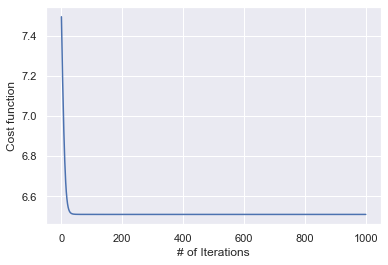

In [717]:

#convergence of the cost function

sns.lineplot(np.arange(len(J)), np.log10(J));
plt.ylabel('Cost function');
plt.xlabel('# of Iterations');

In [718]:
preds_ridge_gd = X_test_sc_wb @ theta 

np.sqrt(mse(y_test, preds_ridge_gd))

2664.5369214261705

- As expected, both the closed form solution as well as the gradient descent solution give the same results.

### Ridge regression with Scikit-learn

In [719]:
ridge_sklearn_pred = Ridge(alpha = 0.1).fit(X_train_sc,y_train).predict(X_test_sc)
np.sqrt(mse(y_test, ridge_sklearn_pred))

2664.536921113815

- **The rmse in both the alternative approaches is the same, as it should be.**

In [720]:
alpha_list_ridge =  np.logspace(-3,3,num=20)

validation_score_mean = []
for alpha in alpha_list_ridge:
    validation_score = cross_val_score(Ridge(alpha = alpha, 
                                             random_state=123,max_iter=5000),X_train_sc,y_train,cv=5,scoring='neg_mean_squared_error')
    validation_score_mean.append(np.mean(np.sqrt(np.abs(validation_score))))

index = np.where(validation_score_mean == np.min(validation_score_mean))[0][0]
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.2f' 
      %(np.min(validation_score_mean), alpha_list_ridge[index])) 

pd.DataFrame(zip(alpha_list_ridge,validation_score_mean),columns=['alpha','Mean CV score (RMSE)'])


The best mean CV score (rmse)=  2549.4529433 which corresponds to alpha = 483.29


,alpha,Mean CV score (RMSE)
0,0.001000,2549.755058
1,0.002069,2549.755057
2,0.004281,2549.755054
3,0.008859,2549.755047
4,0.018330,2549.755035
5,0.037927,2549.755008
6,0.078476,2549.754953
7,0.162378,2549.754840
8,0.335982,2549.754606
9,0.695193,2549.754122


In [721]:
10**(-1)

0.1

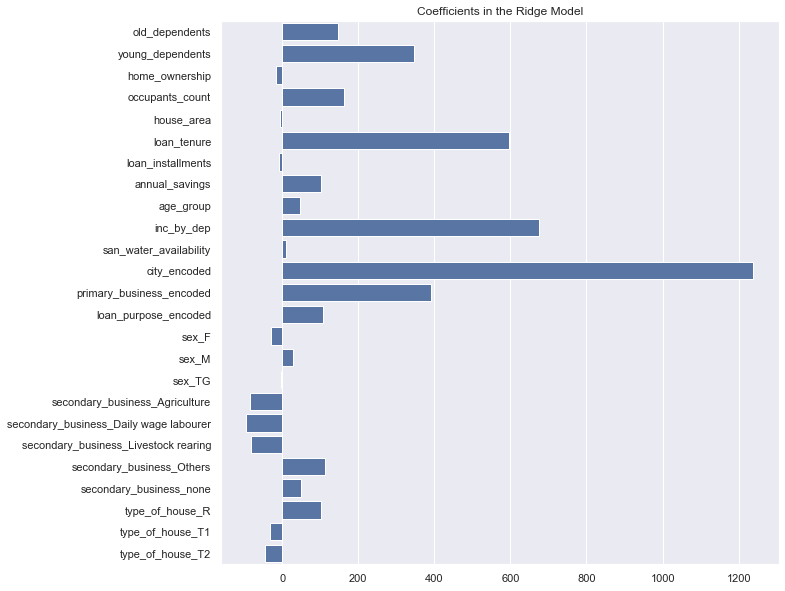

In [722]:
ridge_coef = pd.Series(Ridge(alpha = 200, random_state=110,max_iter=5000).fit(X_train_sc,y_train).coef_, index = X_train.columns)
plt.figure(figsize=(10,10))
sns.barplot(ridge_coef.values, ridge_coef.index,  orient='h',color='b');
plt.title("Coefficients in the Ridge Model");

In [723]:
alpha_list_ridge = np.logspace(1,4,num=20)


Xtrain_fsridge_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)[['loan_purpose_encoded', 'primary_business_encoded', 
                         'city_encoded', 'inc_by_dep', 'annual_savings', 'loan_installments','loan_tenure',
                          'type_of_house_R', 'type_of_house_T1', 'type_of_house_T2','occupants_count']]
Xtest_fsridge_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)[['loan_purpose_encoded', 'primary_business_encoded', 
                         'city_encoded', 'inc_by_dep', 'annual_savings', 'loan_installments','loan_tenure',
                         'type_of_house_R', 'type_of_house_T1', 'type_of_house_T2', 'occupants_count']]

validation_score_mean = []
for alpha in alpha_list_ridge:
    validation_score = cross_val_score(Ridge(alpha = alpha, 
                                             random_state=123,max_iter=5000),Xtrain_fsridge_sc,y_train,cv=5,scoring='neg_mean_squared_error')
    validation_score_mean.append(np.mean(np.sqrt(np.abs(validation_score))))

index = np.where(validation_score_mean == np.min(validation_score_mean))[0][0]
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.2f' 
      %(np.min(validation_score_mean), alpha_list_ridge[index])) 

pd.DataFrame(zip(alpha_list_ridge,validation_score_mean),columns=['alpha','Mean CV score (RMSE)'])


The best mean CV score (rmse)=  2568.7539070 which corresponds to alpha = 88.59


,alpha,Mean CV score (RMSE)
0,10.000000,2568.760598
1,14.384499,2568.759910
2,20.691381,2568.758986
3,29.763514,2568.757793
4,42.813324,2568.756357
5,61.584821,2568.754867
6,88.586679,2568.753907
7,127.427499,2568.754950
8,183.298071,2568.761393
9,263.665090,2568.780673


In [724]:
ridge_mod = Ridge(alpha = 3500, random_state=123,max_iter=5000)

cv_ridge = cross_val_score(ridge_mod,pd.DataFrame(Xtrain_fsridge_sc, columns=Xtrain_fsridge_sc.columns), y_train, cv=5, scoring='neg_root_mean_squared_error' )
print('Mean CV score (RMSE): {}'.format(np.mean(np.abs(cv_ridge))))

ypred_ridgecv = ridge_mod.fit(Xtrain_fsridge_sc, y_train).predict(Xtest_fsridge_sc)
print('RMSE on test set (Ridge regression): {}'.format(rmse(y_test, ypred_ridgecv)))

Mean CV score (RMSE): 2576.472054633624
RMSE on test set (Ridge regression): 2693.0573186758133


### Stacking

In [742]:
from mlxtend.regressor import StackingCVRegressor
import warnings
warnings.filterwarnings("ignore", message = 'FutureWarning')

In [743]:
stack = StackingCVRegressor(regressors=(lasso_model, rf_gs, xgb_gs),
                            meta_regressor=cb_gs,
                            random_state=1111)


for clf, label in zip([lasso_model, rf_gs,xgb_gs, stack], ['Lasso', 
                                                'Random Forest', 'xgboost',
                                                'StackingCVRegressor']):
    scores = cross_val_score(clf, X_train_sc, y_train, cv=5,  scoring='neg_root_mean_squared_error')
    print("RMSE: %0.2f (+/- %0.2f) [%s]" % (
        np.abs(scores).mean(), np.abs(scores).std(), label))

RMSE: 2549.35 (+/- 44.17) [Lasso]
RMSE: 2105.93 (+/- 32.85) [Random Forest]


KeyboardInterrupt: 

In [748]:
stack.fit(X_train_sc, y_train)

KeyboardInterrupt: 

In [ ]:
rmse(y_test,stack.predict(X_test_sc))